# What makes a photo good?

I set out to take a silly, empirical take on a subjective and unanswerable question - what makes a photo good?  

Here we have limited n, ambiguous features, noisy labels/ratings... mostly everything is out of our control. Still, it's fun to try to answer hard questions with limited data ;)  


### Methods  

I attempted to predict two outcomes - one a subjective continuous photo quality rating, the other a binary successful or unsuccessful photo rating. Theris some difficulty with the continuous ratings due to bimodality, a result of the sampling technique (see below). However, the binary outcome gives up some information, since we lose the small variations of "success" and "non-success" within generally successful or unsuccessful photos as classes. (A photo that's I call "successful" may vary from a rating of around 80 to 100, and an unsuccessful one from about 50 to 70.)  

Photo features were derived from metadata where possible with additional features added by hand. Ratings were, of course, by hand.  

Photos were sampled in a two-step process: first I chose the approximately 130 highest-rated photos from my photo library. Then I also sampled another approximately equal number of photos uniformly random with respect to photo index by time. That is, in simpler terms, I just chose every 200th photo.  

### Results  

Unsurprisingly, most effects are pretty weak. The only really strong effect was a positive effect of the "golden hour" near sunset. There are some weaker effects in favor of medium format film (but I shoot much more conservatively with this since it's expensive per-frame) and landscape photos (most of what I shoot "seriously" - as opposed to portraits, events).


#### Boilerplate

In [1]:
# Jan boilerplate, rev 2019/07/24

from datetime import date, datetime
import os
import sys
import pprint
import gc

import numpy as np
import pandas as pd

import scipy as sp
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sklearn as skl

import pymc3 as pm

import xgboost as xgb

# This notebook expects Python 3.
assert(sys.version_info >= (3, 4))

print(f'Python version: {sys.version}')
pd.show_versions()
print('Working directory: ', os.getcwd())
print(f'Current time {datetime.now()}')

# Display more rows, columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 140)

# Auto reload extensions before executing, 
#   so we can edit references without restarting kernel.
#%load_ext autoreload
#%autoreload 2

# Print everything without requiring print statements.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Wide window (fill up screen horizontally)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


# # # Graph styling

# big graphs
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context('talk')
sns.set_palette('GnBu')
sns.set_style('whitegrid')
# fix palette
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10.6, 6)
# fonts
plt.rcParams['font.sans-serif'] = ['Univers LT Std 55 Roman', 'Frutiger CE 55 Roman', 'SchulbuchNord Normal', 'Helvetica', 'sans-serif']
plt.rcParams['font.serif'] = ['Optima', 'serif']
plt.rcParams['font.monospace'] = ['Roboto Mono']
plt.rcParams['font.family'] = "sans-serif"
# big text
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 16}
plt.rc('font', **font)
# slightly thinner linewidth, smaller markers
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['lines.markersize'] = 6
# background
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
# plot colors
from cycler import cycler
hexes = ['#008fd5', '#d14e23', '#8ac42f', '#54904f', '#5cadab', '#540f91', '#ff1cb0', '#ffa01c']
colors = cycler('color', hexes)
plt.rcParams['axes.prop_cycle'] = colors 

# # #


# default percentiles
percentiles = [.05, .10, .25, .5, .75, .90, .95]

# pretty printer
pp = pprint.PrettyPrinter(indent=4)
p = lambda x: pp.pprint(x)

# # #   
# Convenience functions

def do_gc() -> None:
    """
    Prevent memory explosion from unclosed figures
    """
    plt.cla(), plt.clf(), plt.close('all'); import gc; gc.collect()
    return None


def auto_encode_categoricals(df: pd.DataFrame, thresh_uniq_vals:float=.01) -> pd.DataFrame:
    """
    Convert all object / string columns with (# uniq vals / # total vals) < threshold to category.
    Note: Rarely, a column will need to be 'object' (Python object) type 
      to be compatible with Pandas functions.
    df: pd.DataFrame, to downcast to categorical
    thresh_uniq_vals: float, proportion of unique values to require to downcast
    """
    cols = df.select_dtypes(include=['object']).columns.tolist()
    thresh_absolute = thresh_uniq_vals * len(df)
    cat_cols = [
        col for col in cols if (len(df[col].unique()) < thresh_absolute)
    ]
    print('Converting these columns to categorical:')
    p(cat_cols)
    # Have to use a for here due to pd limitation:
    for col in cat_cols:
        df[col] = df[col].copy(deep=True).astype('category')
    return df

def downcast_int(df: pd.DataFrame) -> pd.DataFrame:
    """
    Downcast numeric types in a DataFrame to save memory.
    Note: this will end up dropping duplicated columns, 
          but one would hope you haven't duplicated columns.
    Note 2: some Pandas operations may only exist for floats or higher-bit ints.
    
    df: pd.DataFrame, to downcast
    """
    full = df.copy()
    # We can run into issues if we have duplicated columns - drop them.
    full = df.loc[:,~df.columns.duplicated()]
    df = full.select_dtypes(include=[np.number])
    num_cols = df.columns
    non_num_cols = set(full.columns) - set(df.columns)
    for col in num_cols:
        not_null = not df[col].isnull().any()
        not_small = df[col].abs().mean() > 1.10  # avoid round small floats to 0
        not_fractional = np.isclose(df[col].values, df[col].round(0).values).all()
        downcast = (not_null and not_small and not_fractional)
        if downcast:
            print(f'Downcast column {col}')
            df.loc[:, col] = pd.to_numeric(df[col].copy(deep=True), downcast='integer')
        else:
            pass
        
    df = pd.concat([full[list(non_num_cols)], df], axis='columns')
    return df

do_gc;

Python version: 3.6.10 | packaged by conda-forge | (default, Apr 24 2020, 16:44:11) 
[GCC 7.3.0]

INSTALLED VERSIONS
------------------
commit           : None
python           : 3.6.10.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.4.0-18362-Microsoft
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.0.3
numpy            : 1.18.4
pytz             : 2020.1
dateutil         : 2.8.1
pip              : 20.1
setuptools       : 46.1.3.post20200325
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.14.0
pandas_datareader: None
bs4              : None
bottleneck       : 1.3.2

### Load Data

In [86]:
ratings = pd.read_csv('./photo_ratings_2020_05.tsv', sep='\t')

# exclude rare category of mandatory newspaper building photos 
#   as they cause an effect of "photo style" that's not terribly meaningful/useful
ratings = ratings.loc[ratings.photo_style != 'building_mug']

ratings['taken_at'] = ratings.date + ' ' + ratings.time
ratings['taken_at'] = pd.to_datetime(ratings.taken_at)
ratings.taken_at

ratings['month'] = ratings['taken_at'].dt.month
ratings['year'] = ratings['taken_at'].dt.year

seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
ratings['ord_season'] = ratings['taken_at'].dt.month.map(month_to_season) 

ratings['date_ord'] = pd.to_timedelta(ratings.taken_at - ratings.taken_at.min()) / pd.to_timedelta('1d')
print('min date =', ratings.taken_at.min() )
print('max date =', ratings.taken_at.max() )

# point and shoot bool
ratings['camera_p_n_s'] = ratings.camera.isin(['x100', 'ricoh_gr3', 'contax_t3']).astype('int')

ratings.info()
ratings



0     2011-11-09 13:41:00
1     2011-11-09 15:47:00
2     2012-01-22 21:54:00
3     2012-03-04 10:56:00
4     2012-09-23 17:47:00
              ...        
242   2019-12-28 13:18:00
243   2020-03-04 16:12:00
244   2020-04-07 16:55:00
245   2020-04-07 14:52:00
246   2020-04-26 15:17:00
Name: taken_at, Length: 244, dtype: datetime64[ns]

min date = 2010-11-26 10:44:00
max date = 2020-04-26 15:17:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 244 entries, 0 to 246
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   photo_description      244 non-null    object        
 1   date                   244 non-null    object        
 2   time                   244 non-null    object        
 3   camera                 244 non-null    object        
 4   35equiv_focal          244 non-null    int64         
 5   film_digital           244 non-null    object        
 6   format                 244 non-null    object        
 7   shooting_circumstance  244 non-null    object        
 8   filmstock              42 non-null     object        
 9   lighting               244 non-null    object        
 10  minutes_before_sunset  0 non-null      float64       
 11  photo_style            244 non-null    object        
 12  ra

photo_description        date   time   camera  35equiv_focal film_digital      format  \
0                            man with a megaphone  2011/11/09  13:41       5d             85      digital  ff_digital   
1                          police officer praying  2011/11/09  15:47       5d             85      digital  ff_digital   
2                 man playing guitar with streaks  2012/01/22  21:54       5d             85      digital  ff_digital   
3    man holding a football with upside down flag  2012/03/04  10:56       5d             85      digital  ff_digital   
4            football player with horizontal ball  2012/09/23  17:47       5d             85      digital  ff_digital   
..                                            ...         ...    ...      ...            ...          ...         ...   
242            24000: plant at huntington library  2019/12/28  13:18      m10             50      digital  ff_digital   
243                        24217: american bag co  2020/03/04  16:12  gfx_100             40      digital  mf_digital   
244      24400: self portrait wearing ramie shirt  2020/04/07  16:55  gfx_100             50      digital  mf_digital   
245                     24600: TA w/ studio flash  2020/04/07  14:52      m10             50      digital  ff_digital   
246          24800: TA weird lean studio portrait  2020/04/26  15:17  gfx_100             50      digital  mf_digital   

    shooting_circumstance filmstock      lighting  minutes_before_sunset  photo_style  rating  score note            taken_at  month  \
0               newspaper       NaN      non-soft                    NaN  event/party     2.0     80  NaN 2011-11-09 13:41:00     11   
1               newspaper       NaN      non-soft                    NaN  event/party     2.0     88  NaN 2011-11-09 15:47:00     11   
2               newspaper       NaN    artificial                    NaN  event/party     2.0     88  NaN 2012-01-22 21:54:00      1   
3               newspaper       NaN      non-soft                    NaN     portrait     2.0     88  NaN 2012-03-04 10:56:00      3   
4               newspaper       NaN  studio flash                    NaN     portrait     2.0     81  NaN 2012-09-23 17:47:00      9   
..                    ...       ...           ...                    ...          ...     ...    ...  ...                 ...    ...   
242              vacation       NaN      non-soft                    NaN    landscape     0.0     58  NaN 2019-12-28 13:18:00     12   
243            after_work       NaN          soft                    NaN    landscape     0.0     55  NaN 2020-03-04 16:12:00      3   
244           intentional       NaN  studio flash                    NaN     portrait     0.0     50  NaN 2020-04-07 16:55:00      4   
245           intentional       NaN  studio flash                    NaN     portrait     0.0     57  NaN 2020-04-07 14:52:00      4   
246           intentional       NaN  studio flash                    NaN     portrait     0.0     57  NaN 2020-04-26 15:17:00      4   

     year  ord_season     date_ord  camera_p_n_s  
0    2011           4   348.122917             0  
1    2011           4   348.210417             0  
2    2012           1   422.465278             0  
3    2012           2   464.008333             0  
4    2012           4   667.293750             0  
..    ...         ...          ...           ...  
242  2019           1  3319.106944             0  
243  2020           2  3386.227778             0  
244  2020           2  3420.257639             0  
245  2020           2  3420.172222             0  
246  2020           2  3439.189583             0  

[244 rows x 21 columns]

In [ ]:
# also add minutes before sunset feature

from astral import Astral
from datetime import date

city_name = 'San Francisco'
a = Astral()
a.solar_depression = 'civil'
city = a[city_name]
#sun = city.sun(date=date(2019, 5, 10), local=True)
#sun['sunset']
#pd.Series(ratings.taken_at.dt.to_pydatetime()).apply(lambda x: x.date())

def calc_sunset(date_: datetime.date) -> float:
    """
    Assume I'm always in the Bay. It'll be a bit off elsewhere, but I don't have lat-lon for most photos.
    """
    sun = city.sun(date=date_, local=True)
    return sun['sunset']

ratings['sunset'] = pd.to_datetime(
    pd.Series(ratings.taken_at.dt.to_pydatetime())
    .apply(lambda x: x.date())
    .apply(calc_sunset)
)
ratings.sunset

ratings['minutes_before_sunset'] = (  # strip tz info and subtract two without timezones
    (ratings['sunset'].dt.tz_localize(None) - ratings['taken_at']) / pd.to_timedelta('1m')
)

# weird offset error where we get a diff day's sunset
# worked fine yesterday, perhaps some weird rate limitation on the API?
sunset_same_date = (ratings['sunset'].dt.tz_localize(None) - ratings['taken_at'].dt.tz_localize(None)).abs() < pd.to_timedelta('1d')
ratings.loc[~sunset_same_date]
ratings['minutes_before_sunset'] = ratings.minutes_before_sunset.loc[~sunset_same_date]  # never >24 hrs before sunset

avg_sunset_by_mo = ratings.groupby('month').sunset.apply(  # average hour plus avg mins (converted to fractional hours)
    lambda x: ((x.dt.hour.mean()) + (x.dt.minute.mean() / 60.0))
)
avg_sunset_by_mo

def calc_sunset_by_mo_fallback(ser: pd.Series, avg_sunset_by_mo):
    """
    Expects to be applied row-wise series with all columns.
    """
    #print(ser)
    mo = ser.month
    sunset = avg_sunset_by_mo[mo]
    minutes_before_sunset = (sunset - (ser.taken_at.hour + ser.taken_at.minute / 60.0)) * 60
    return minutes_before_sunset
    
ratings.loc[~sunset_same_date, 'minutes_before_sunset'] = ratings.apply(
    lambda x: calc_sunset_by_mo_fallback(x, avg_sunset_by_mo), axis='columns'
)

## Basic analyses by factor

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.5, 1.0, 'Effect of factor: camera')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

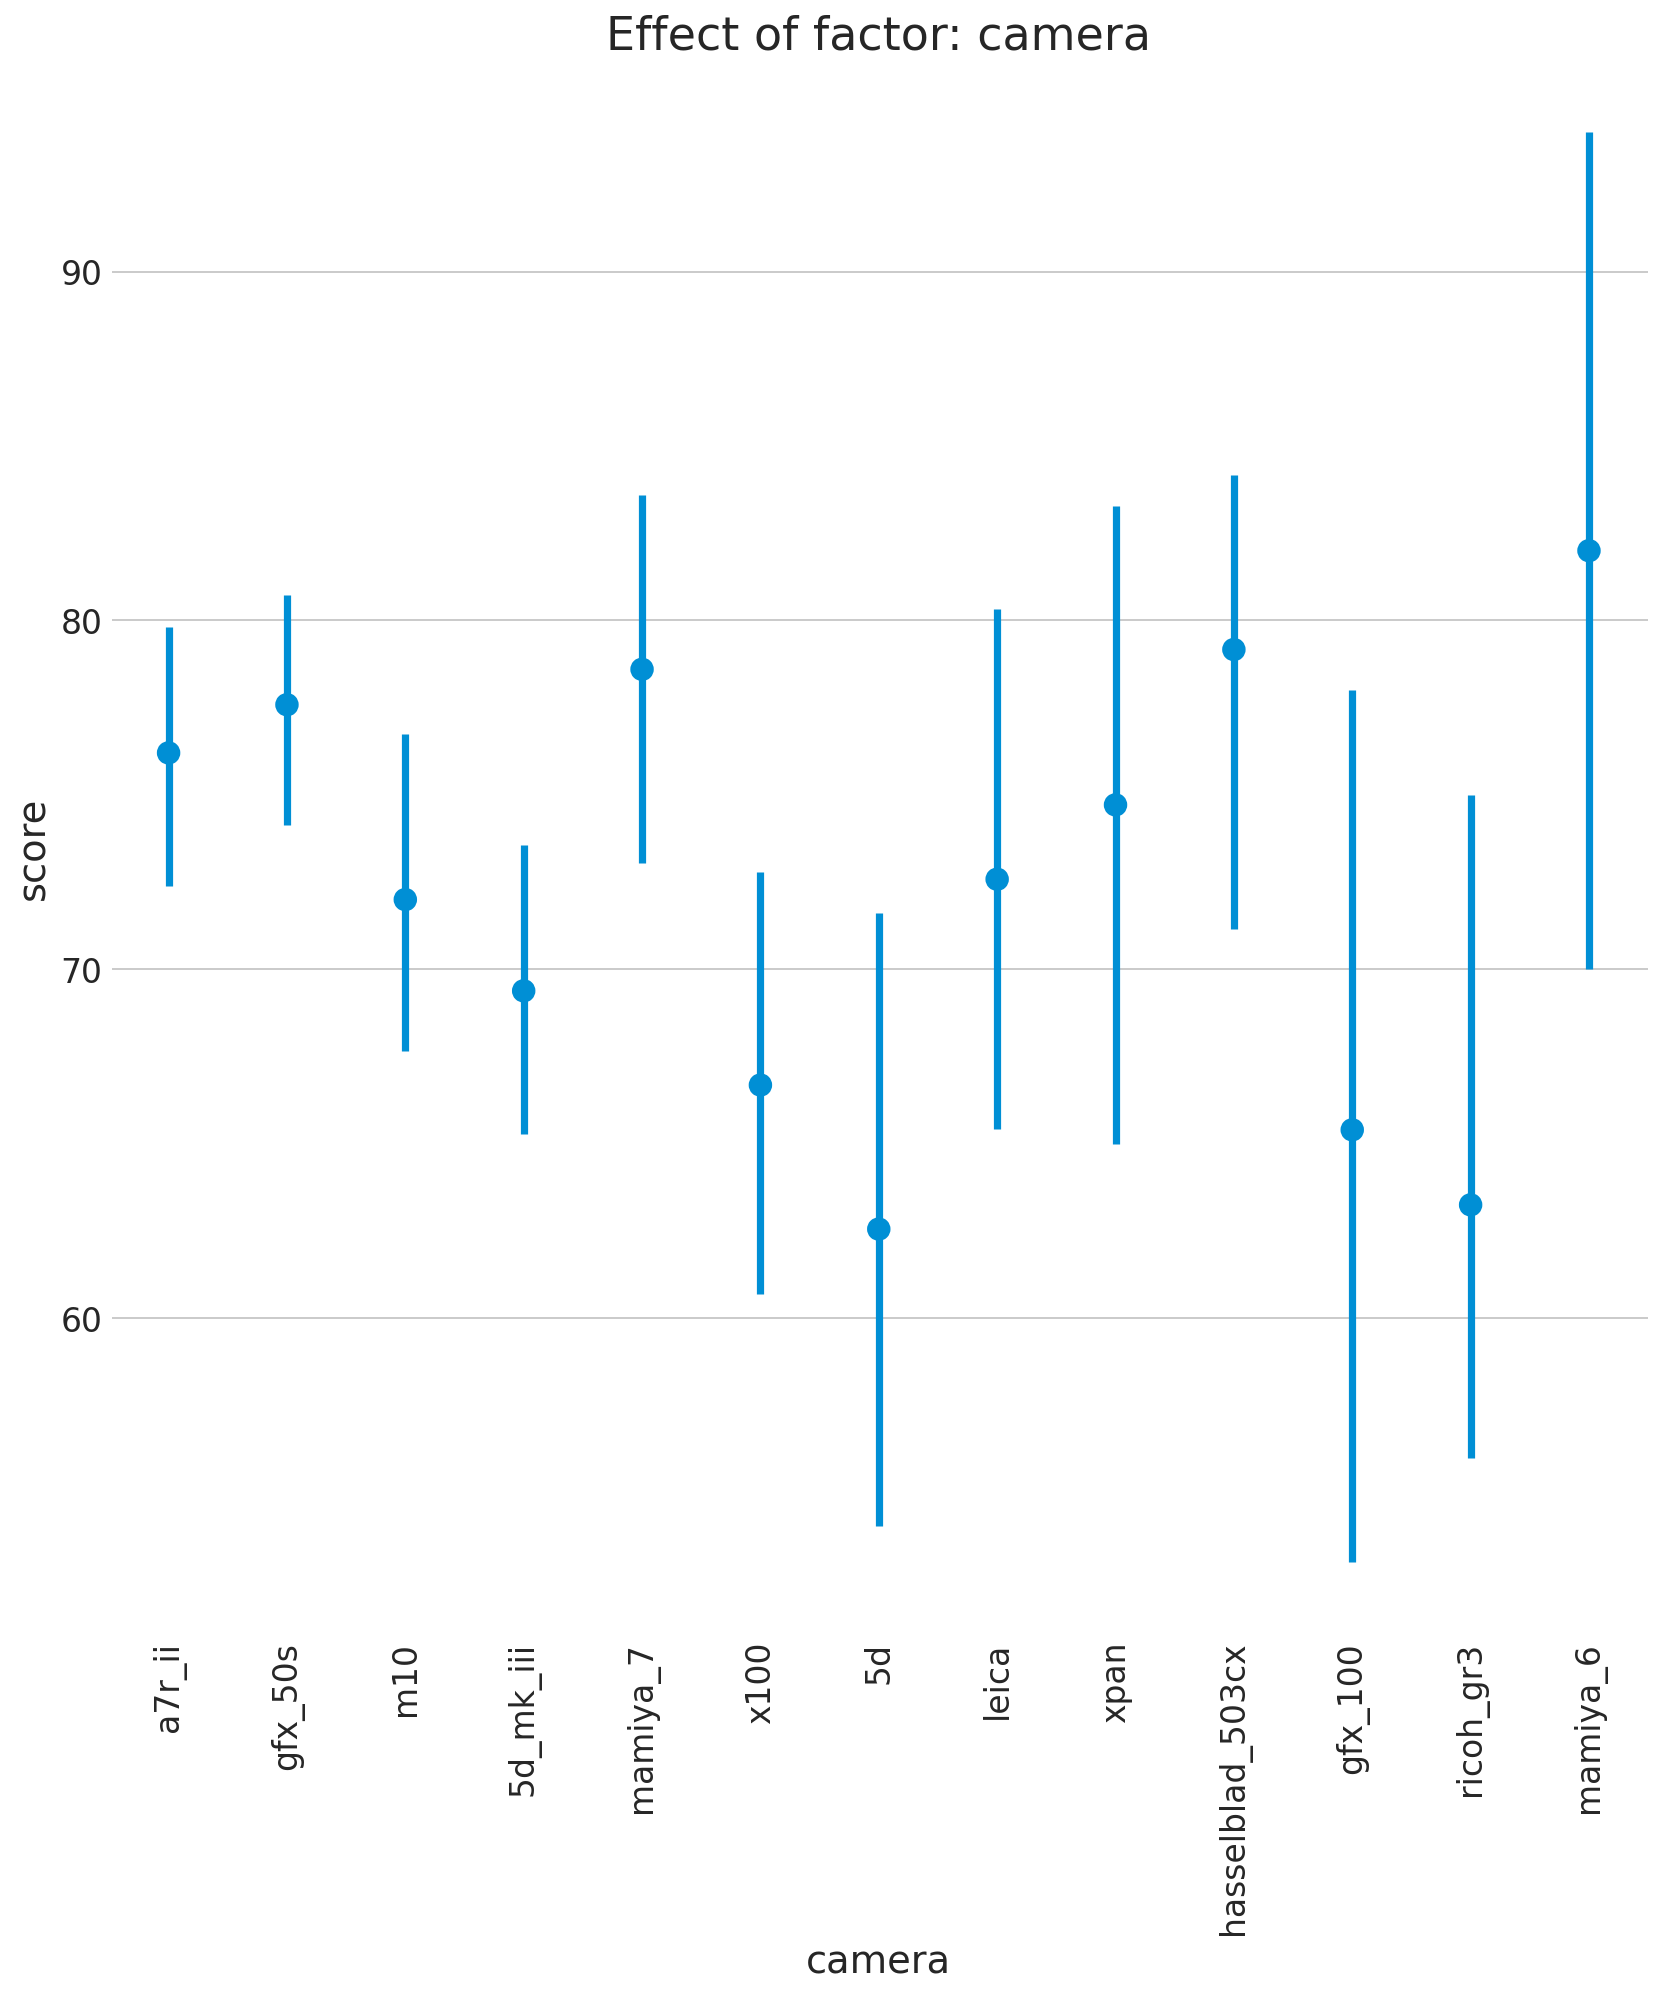

Text(0.5, 1.0, 'Effect of factor: camera_p_n_s')

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

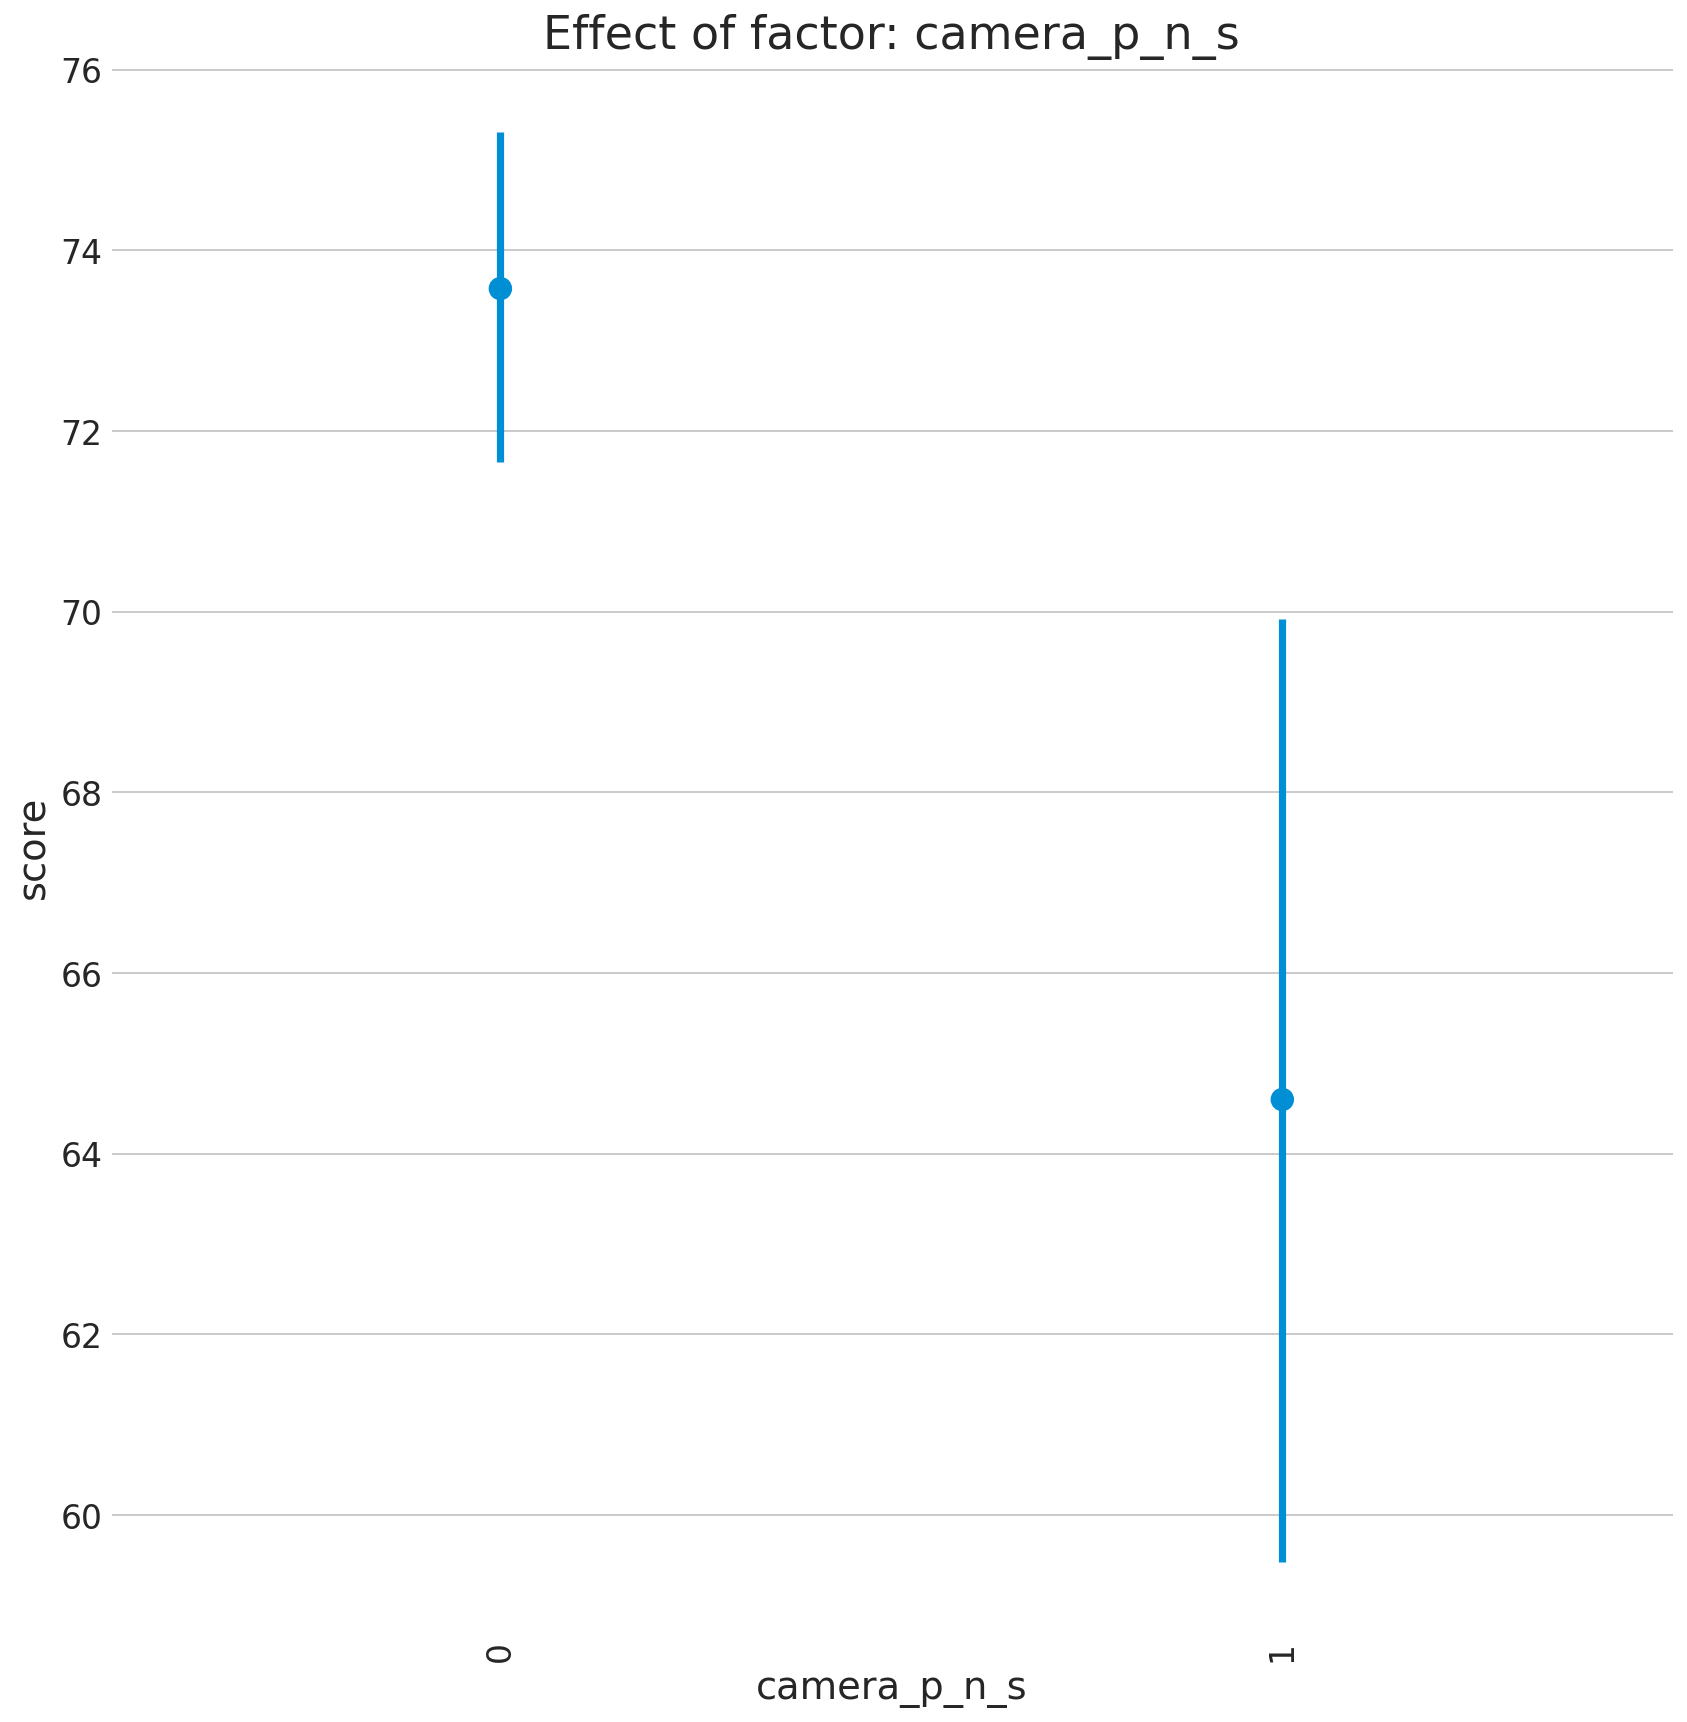

Text(0.5, 1.0, 'Effect of factor: 35equiv_focal')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

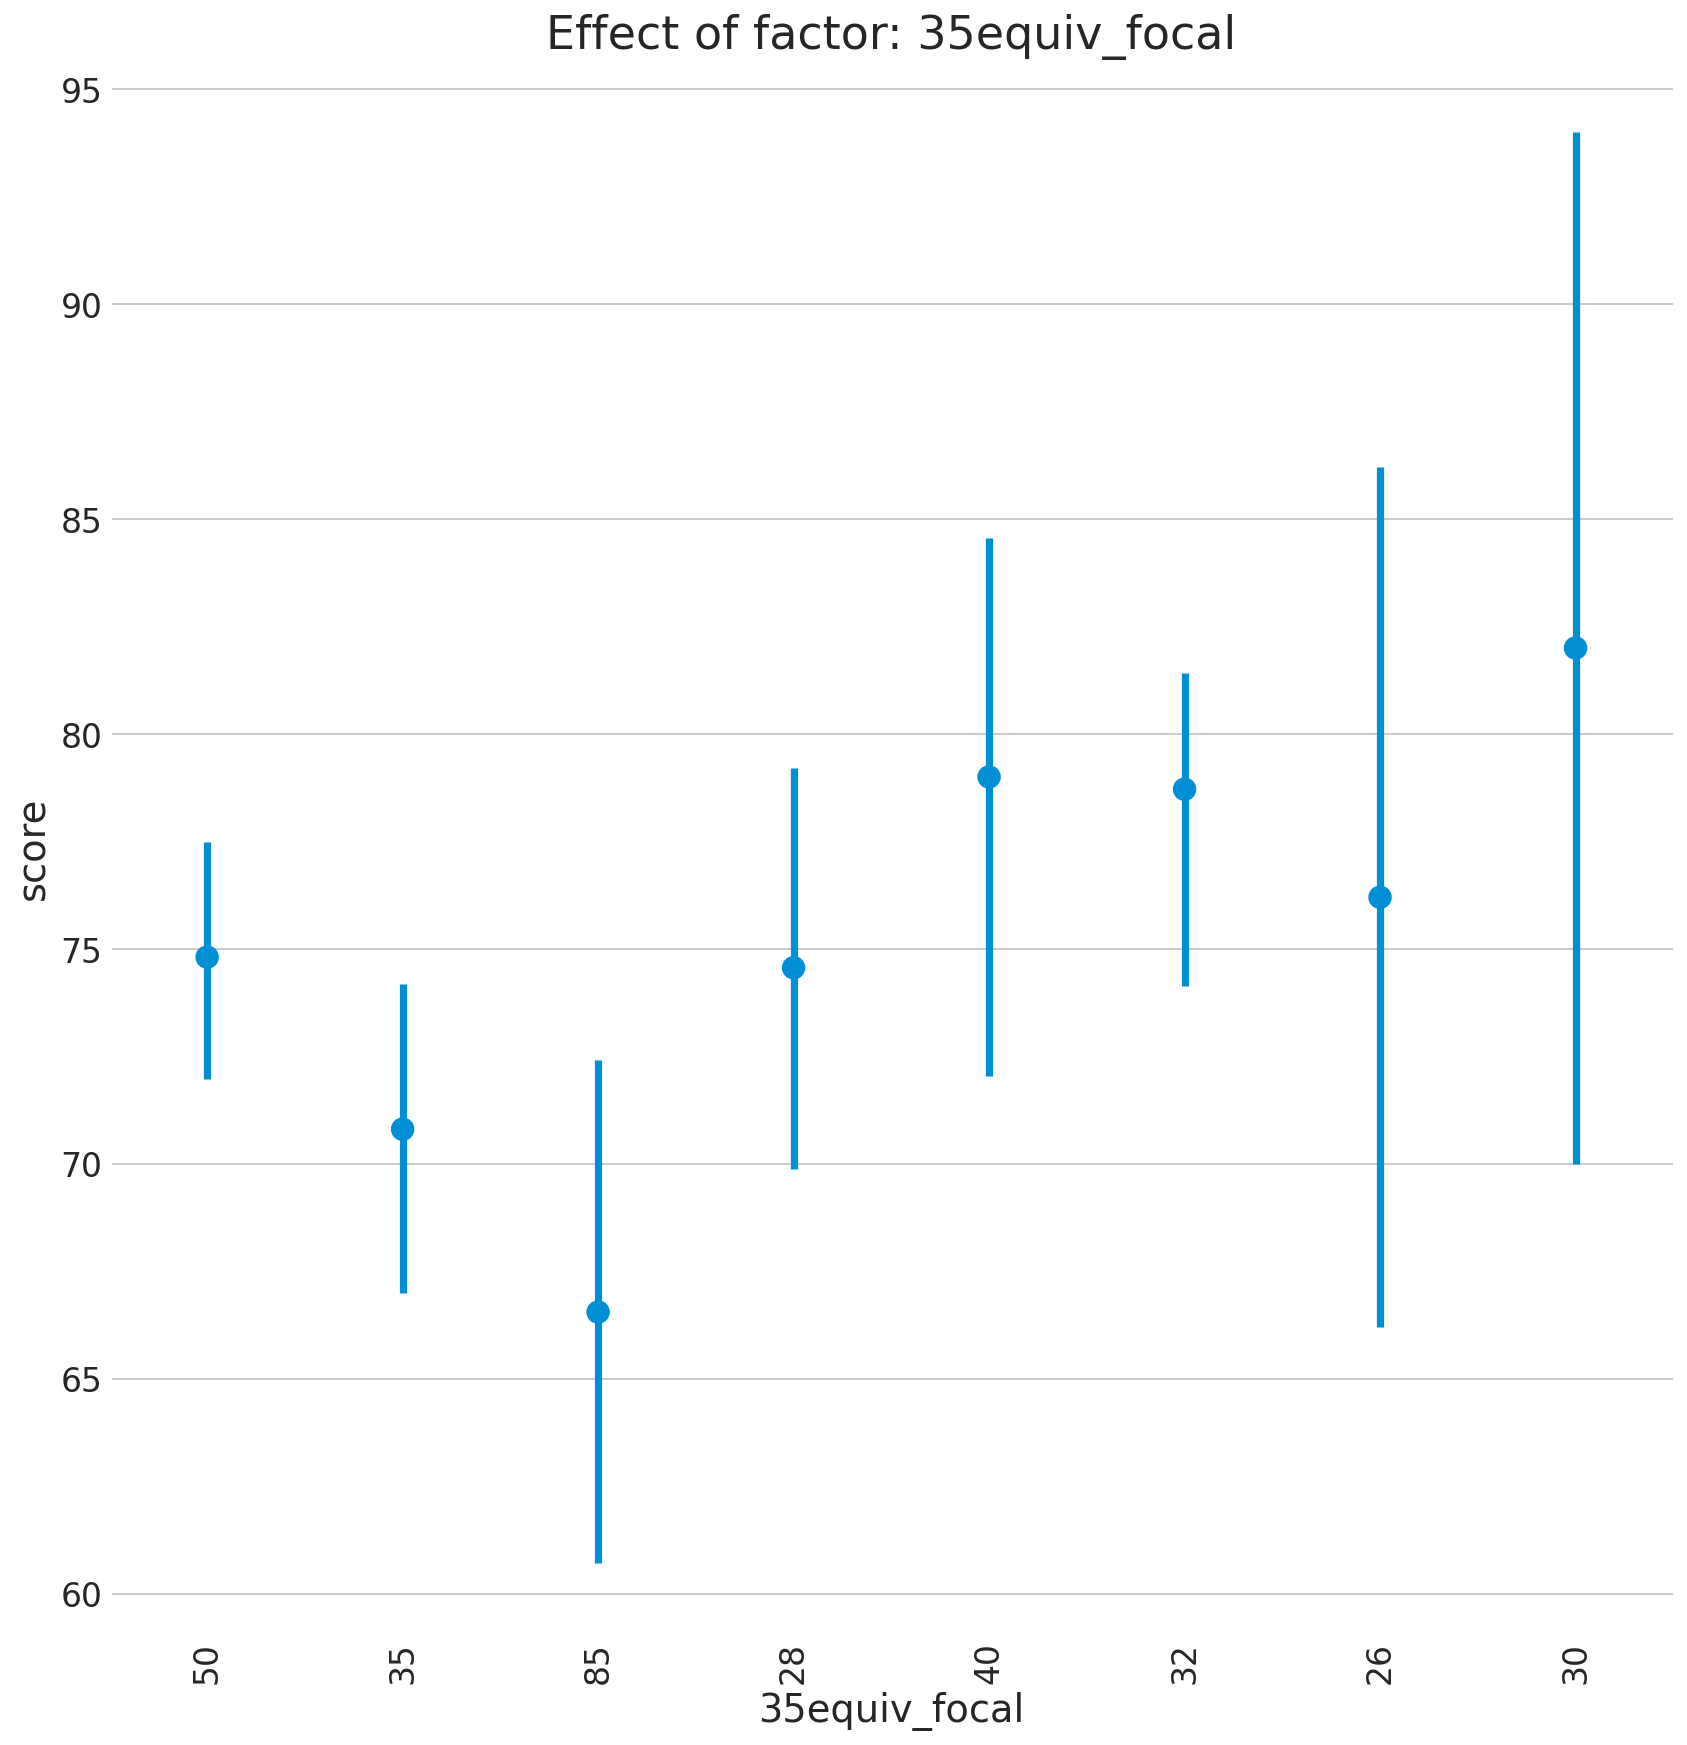

Text(0.5, 1.0, 'Effect of factor: film_digital')

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

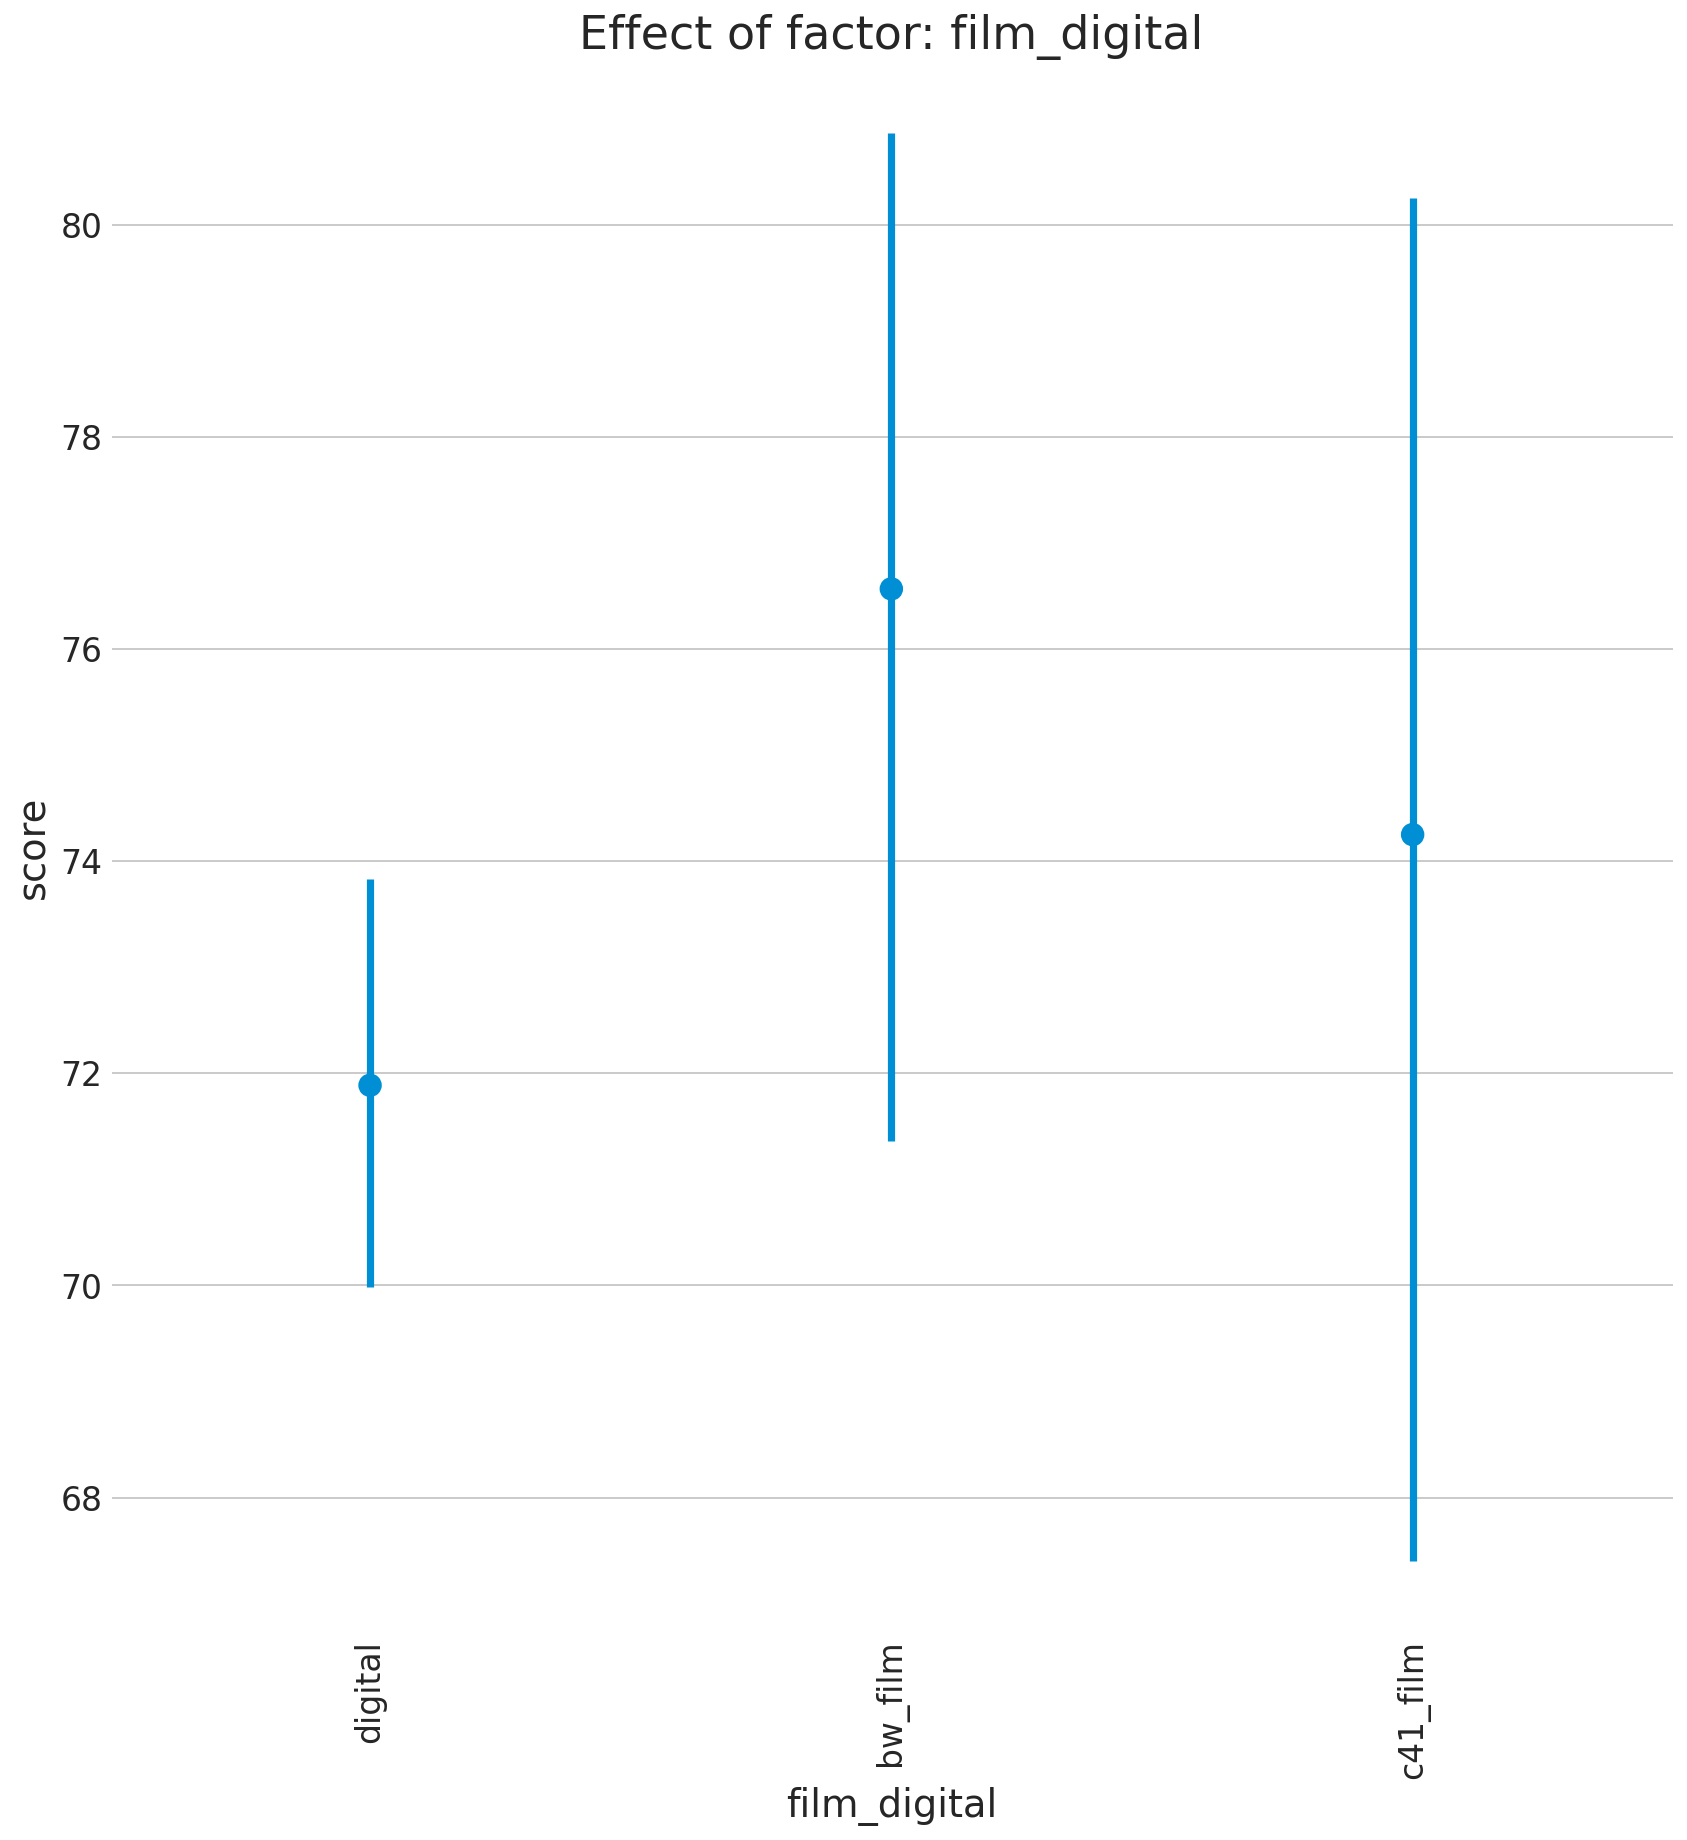

Text(0.5, 1.0, 'Effect of factor: format')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

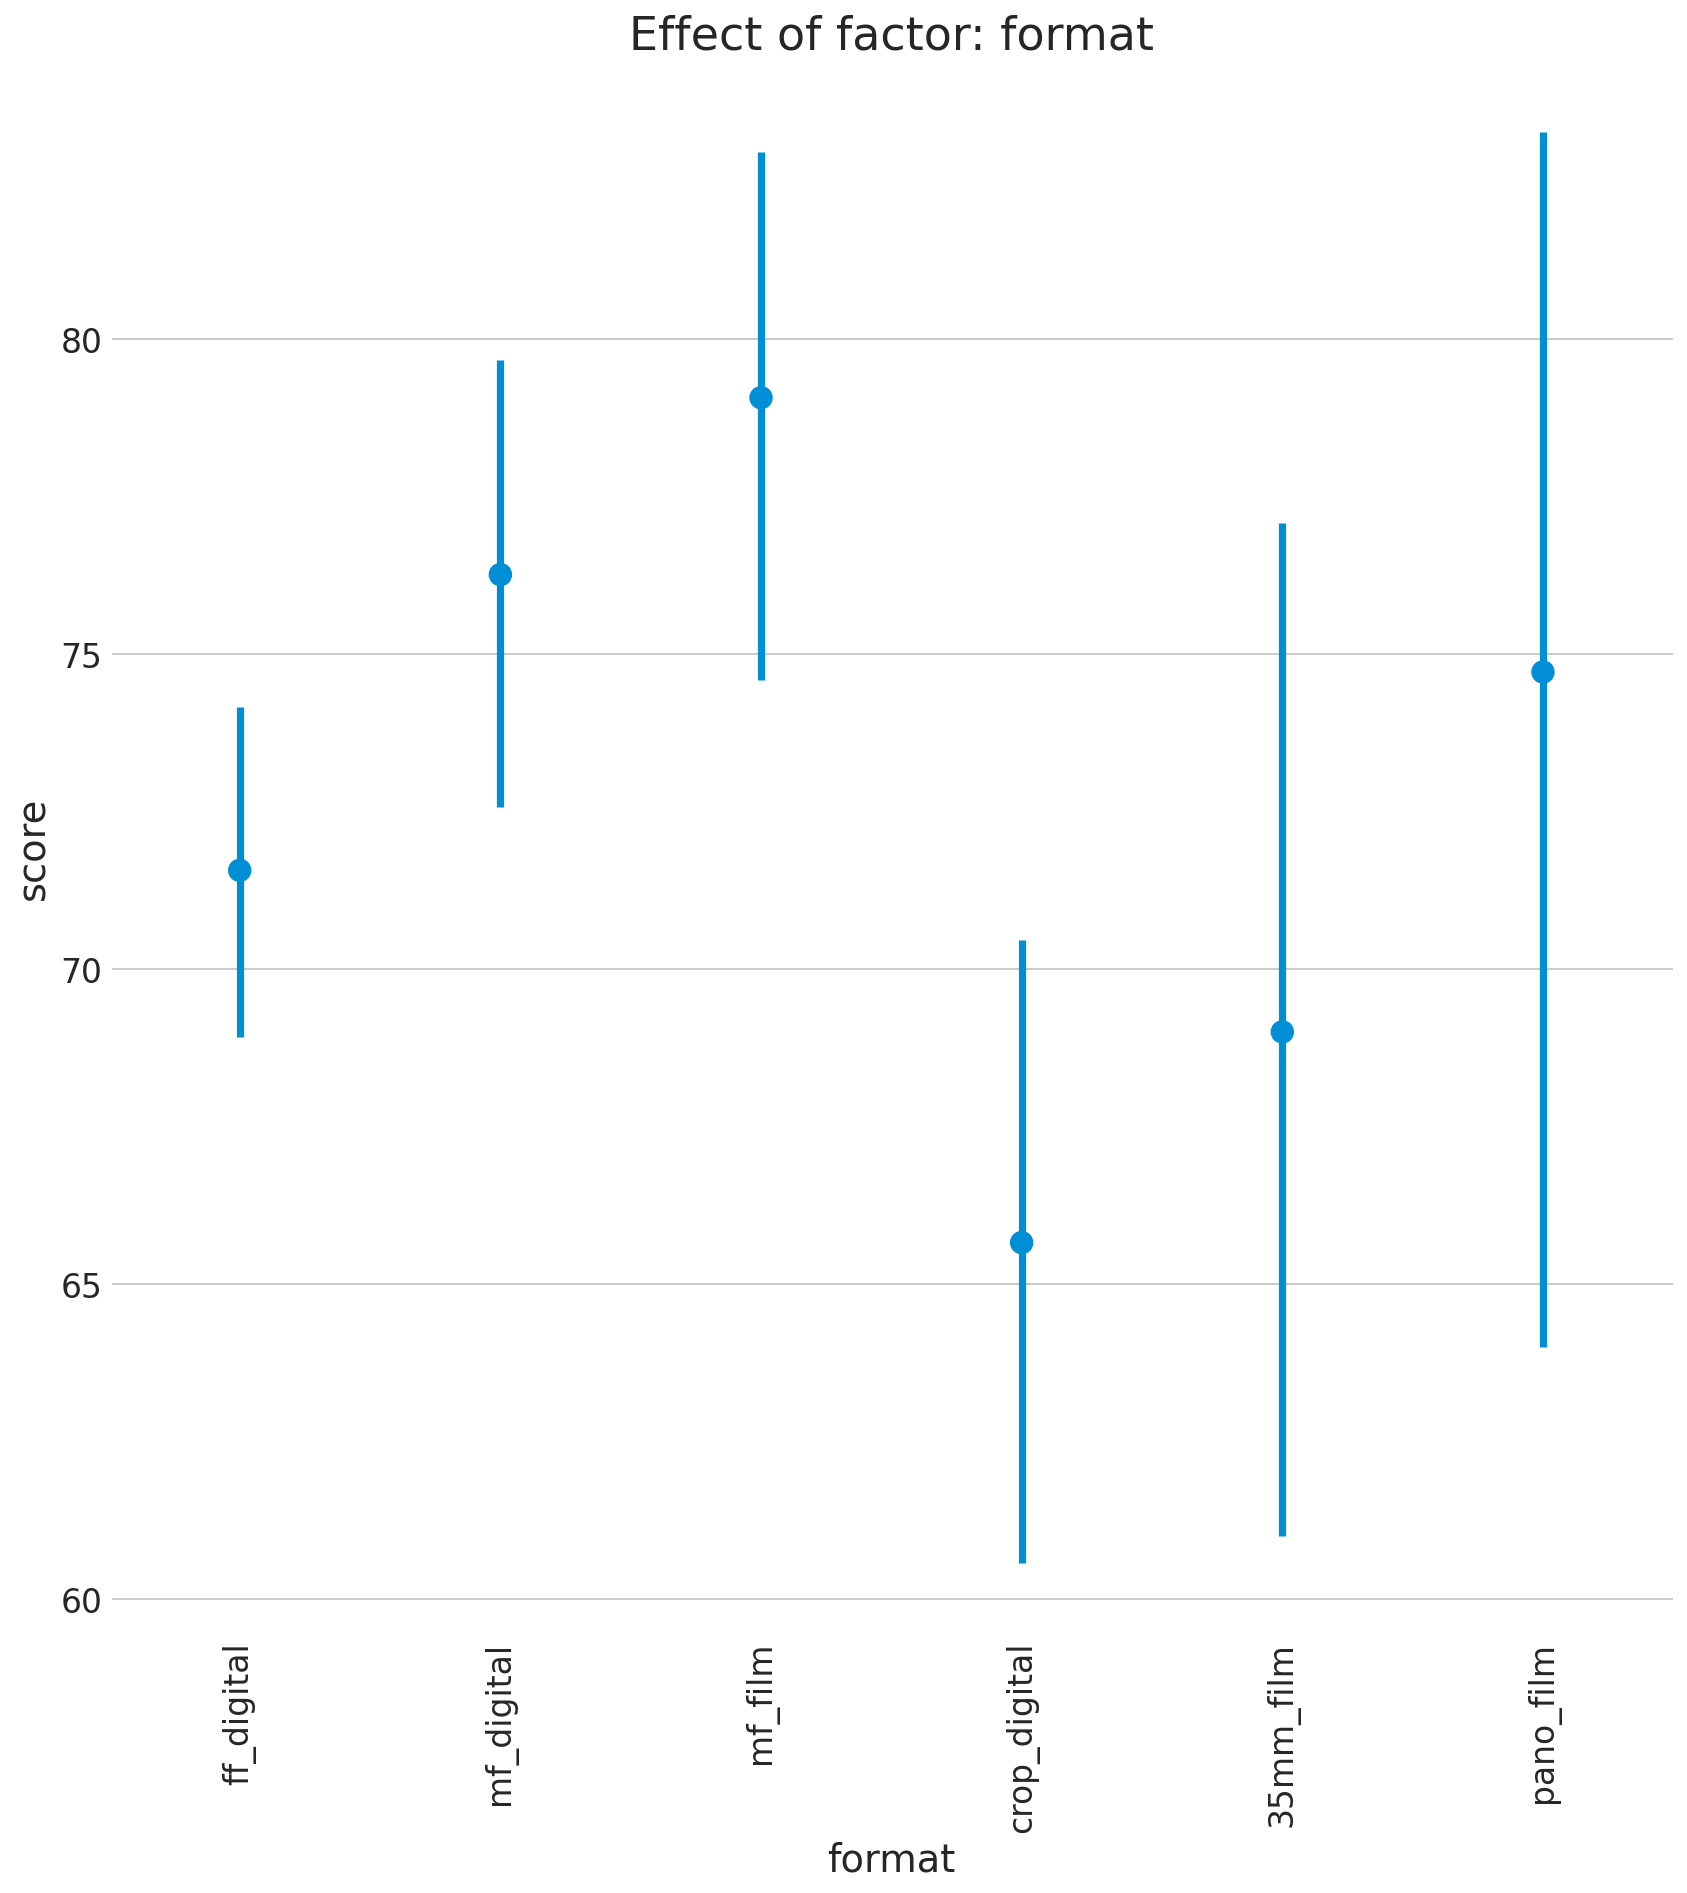

Text(0.5, 1.0, 'Effect of factor: shooting_circumstance')

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

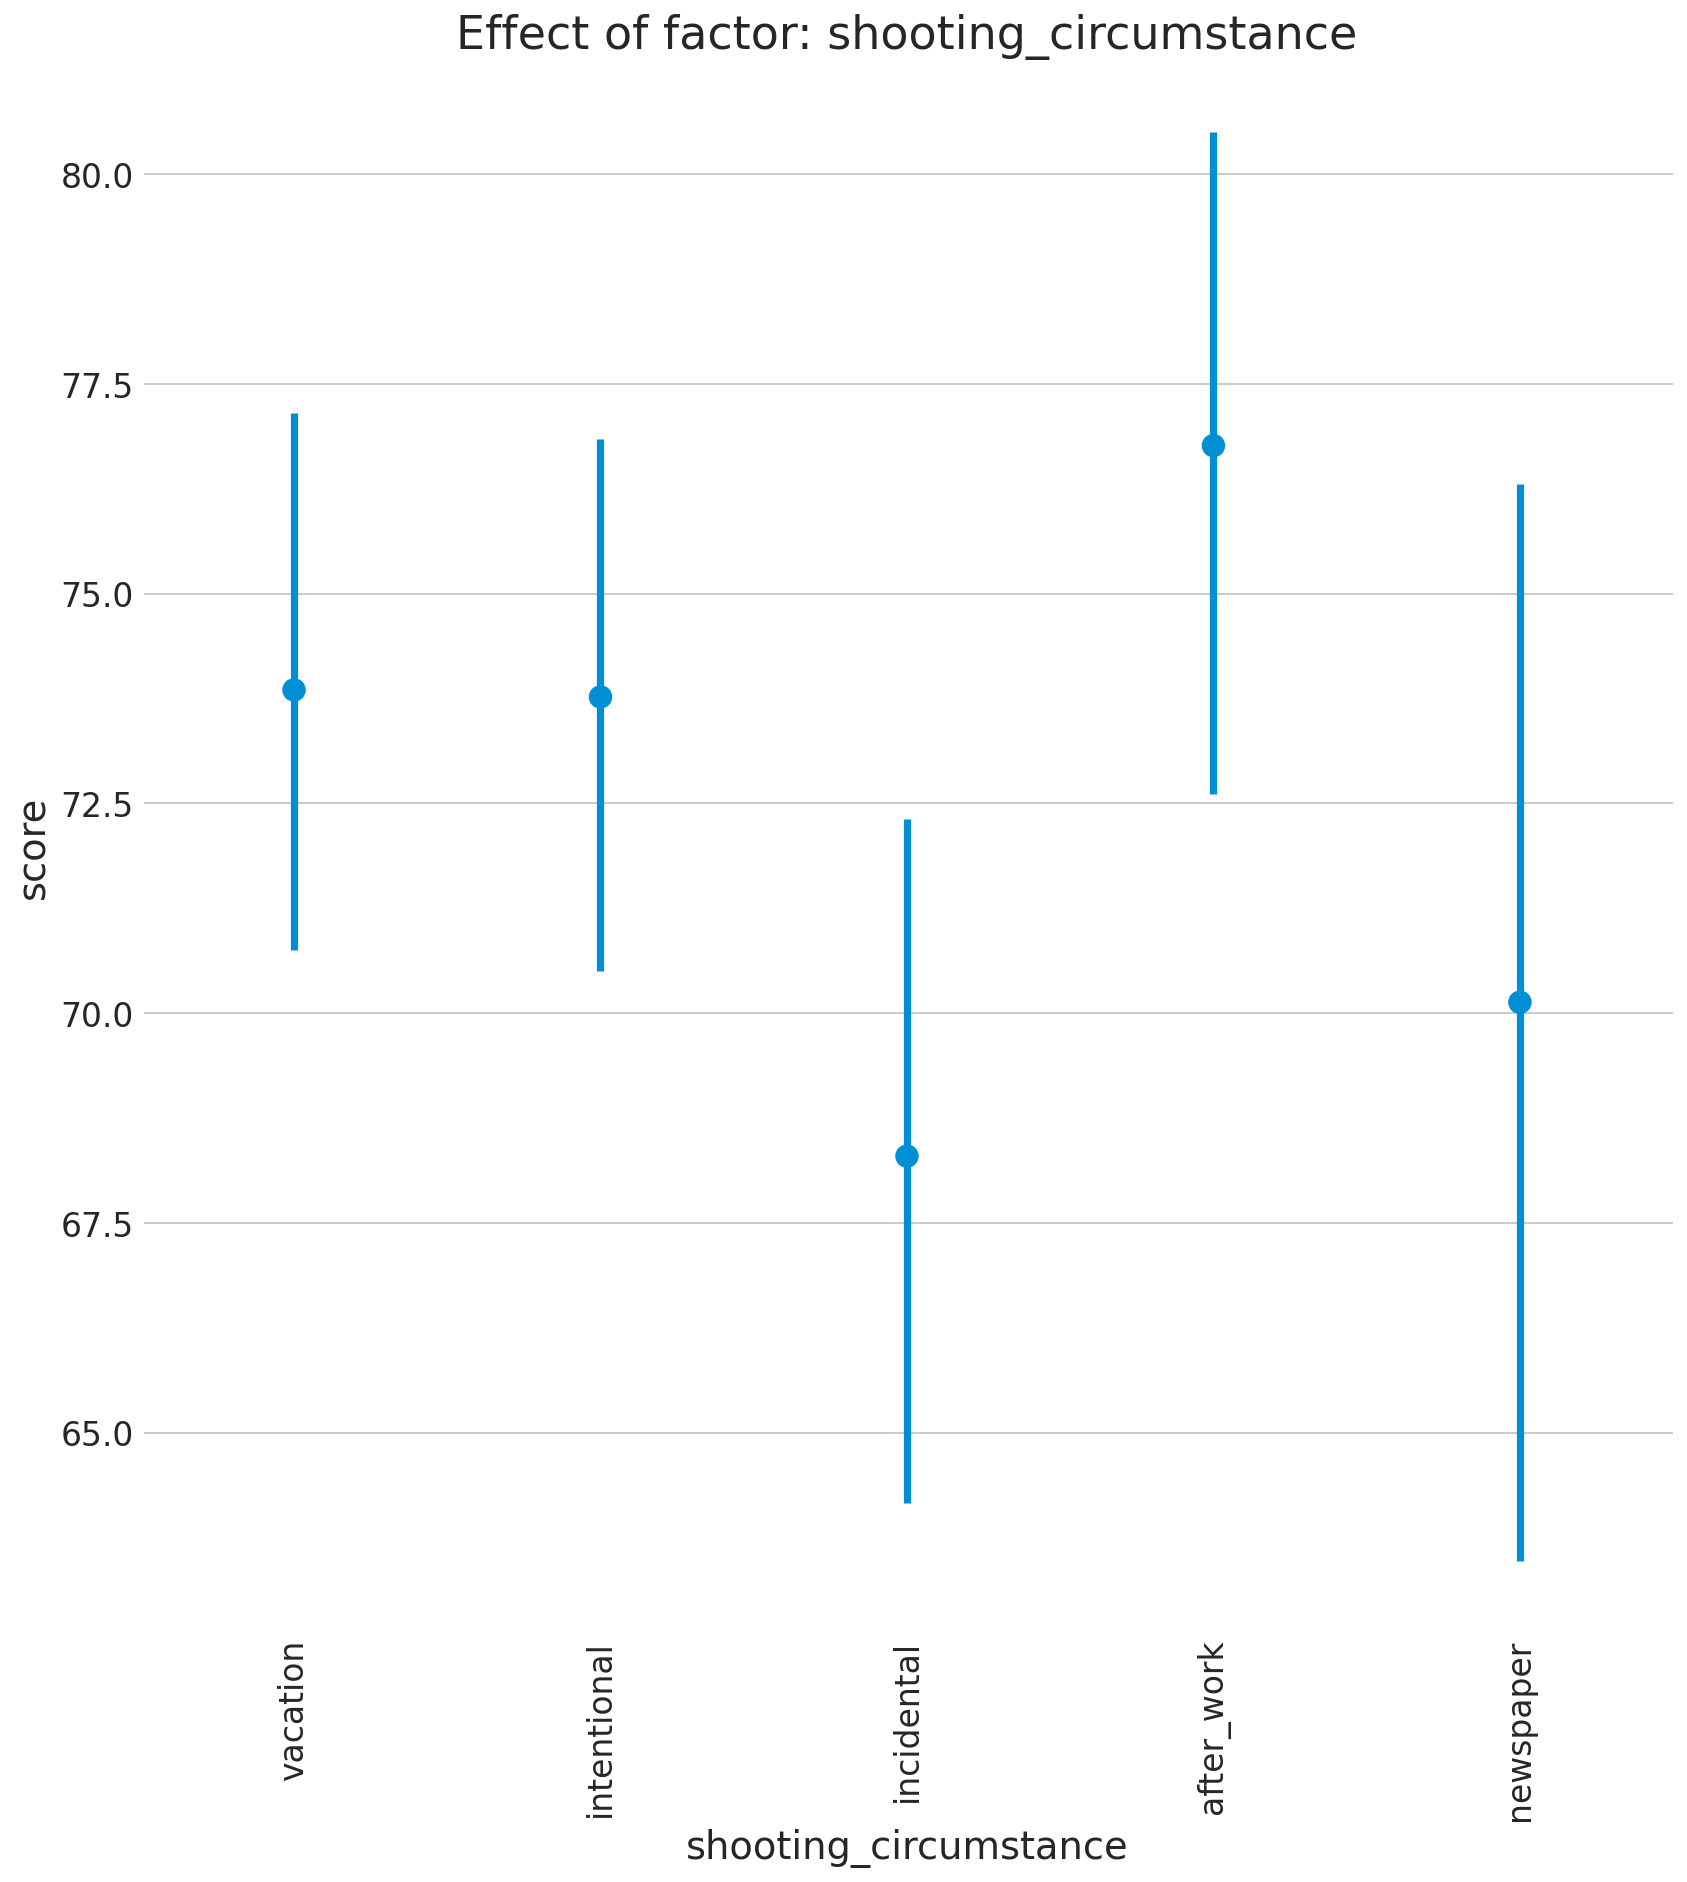

Text(0.5, 1.0, 'Effect of factor: filmstock')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

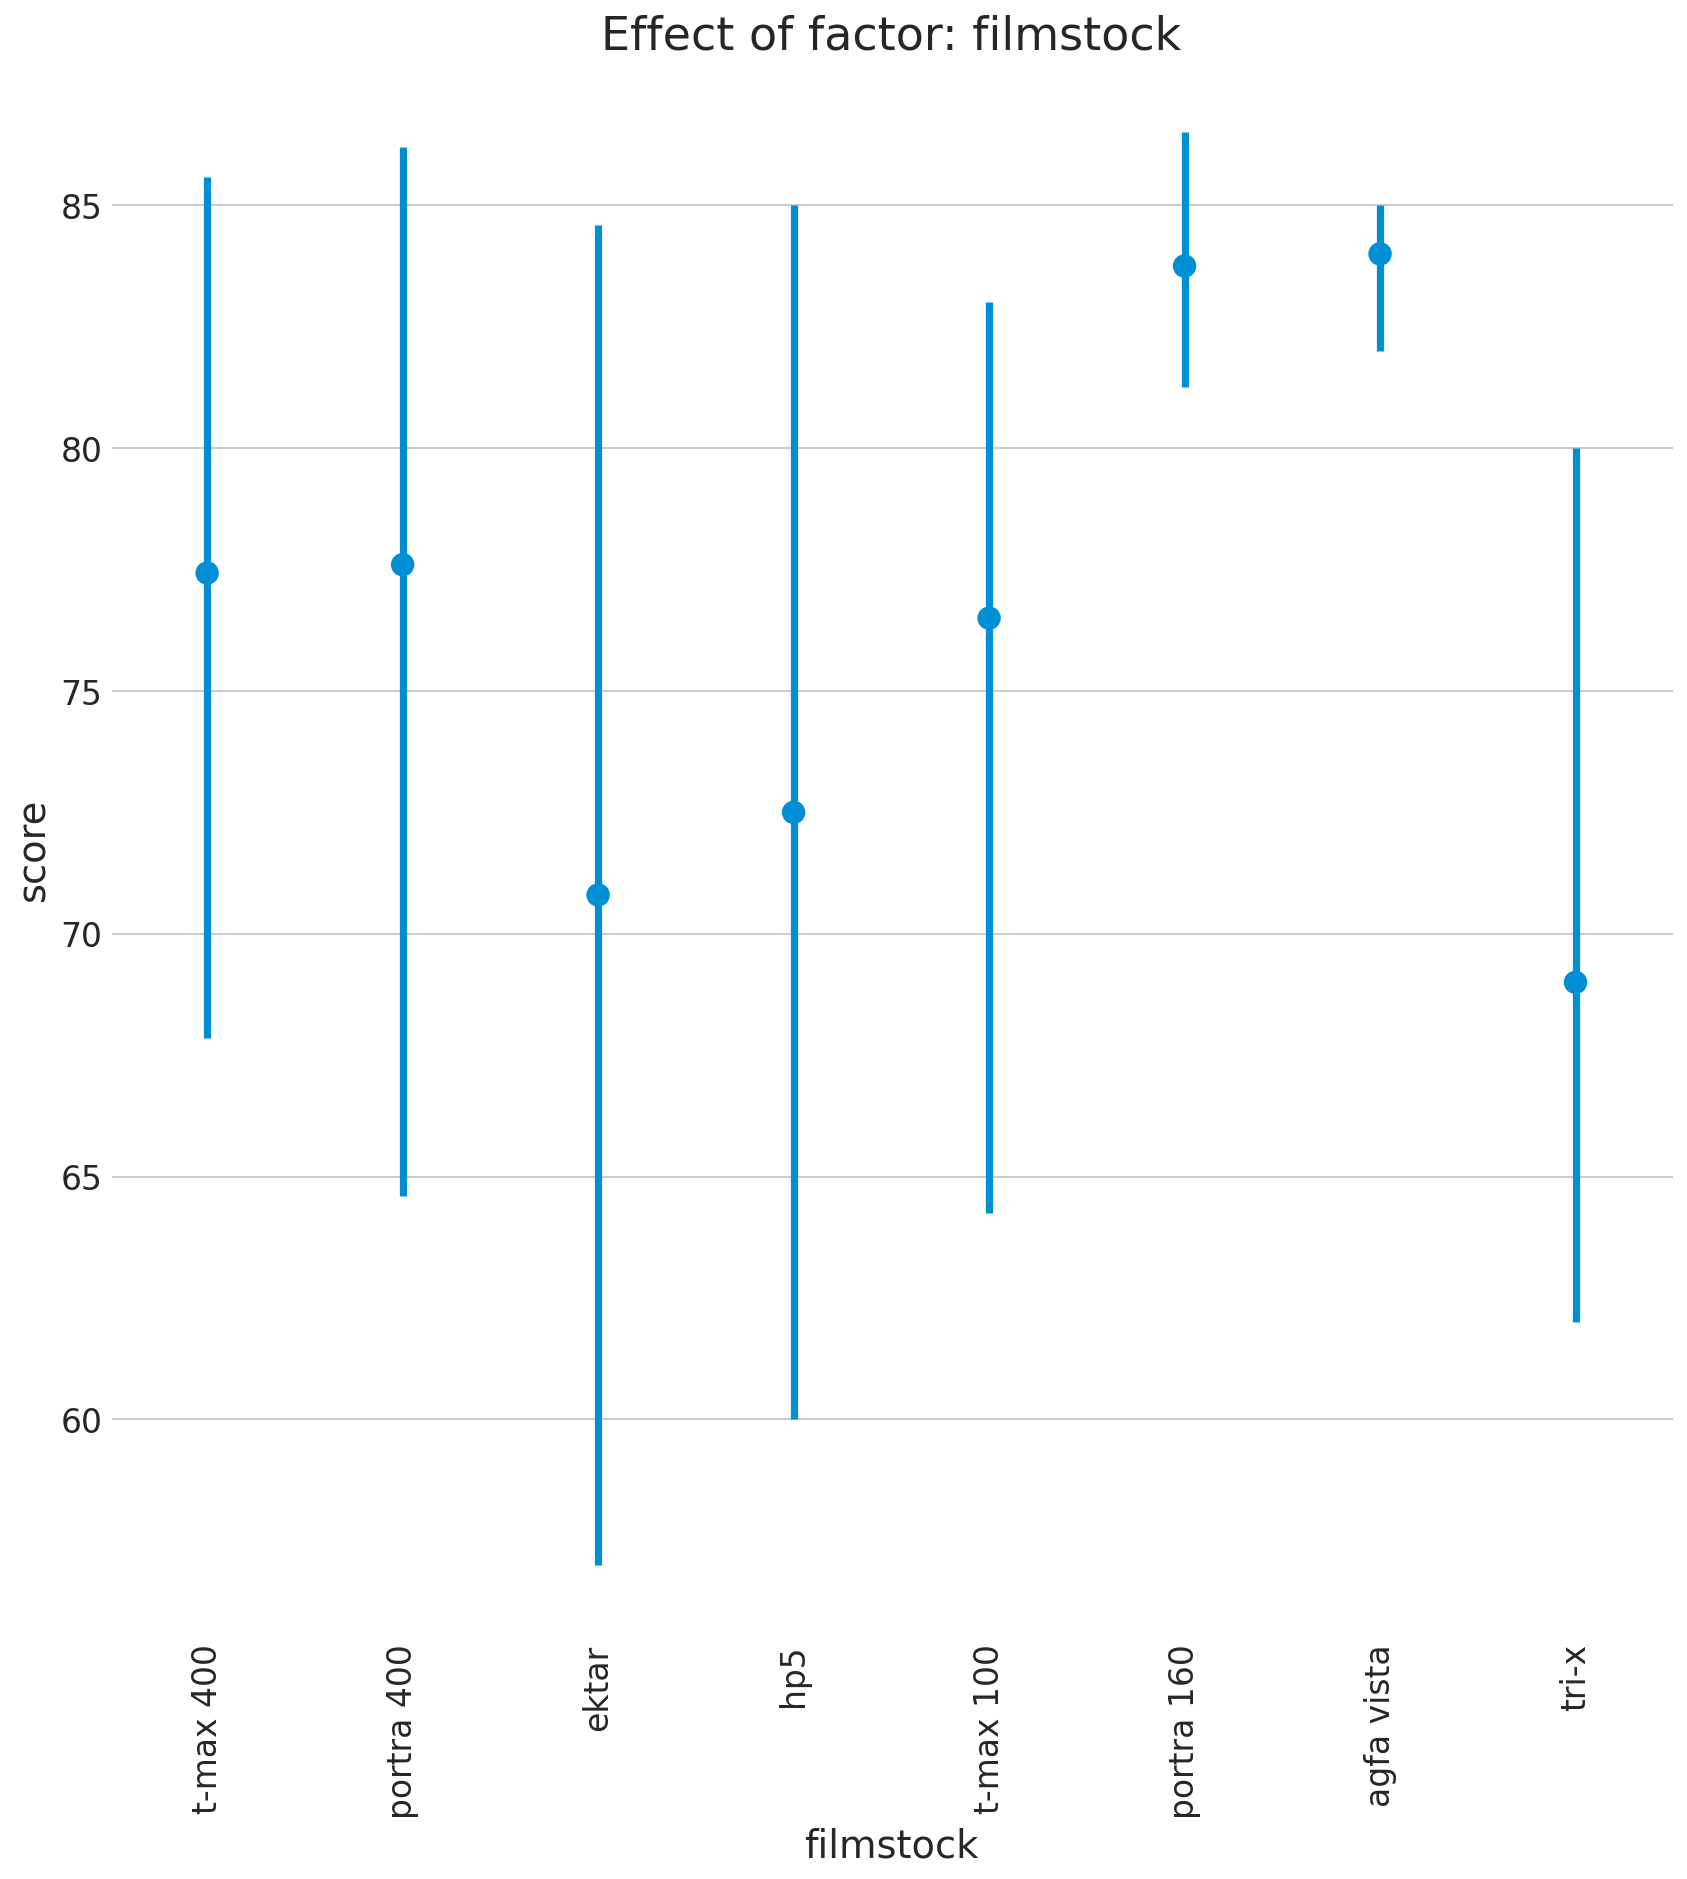

Text(0.5, 1.0, 'Effect of factor: lighting')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

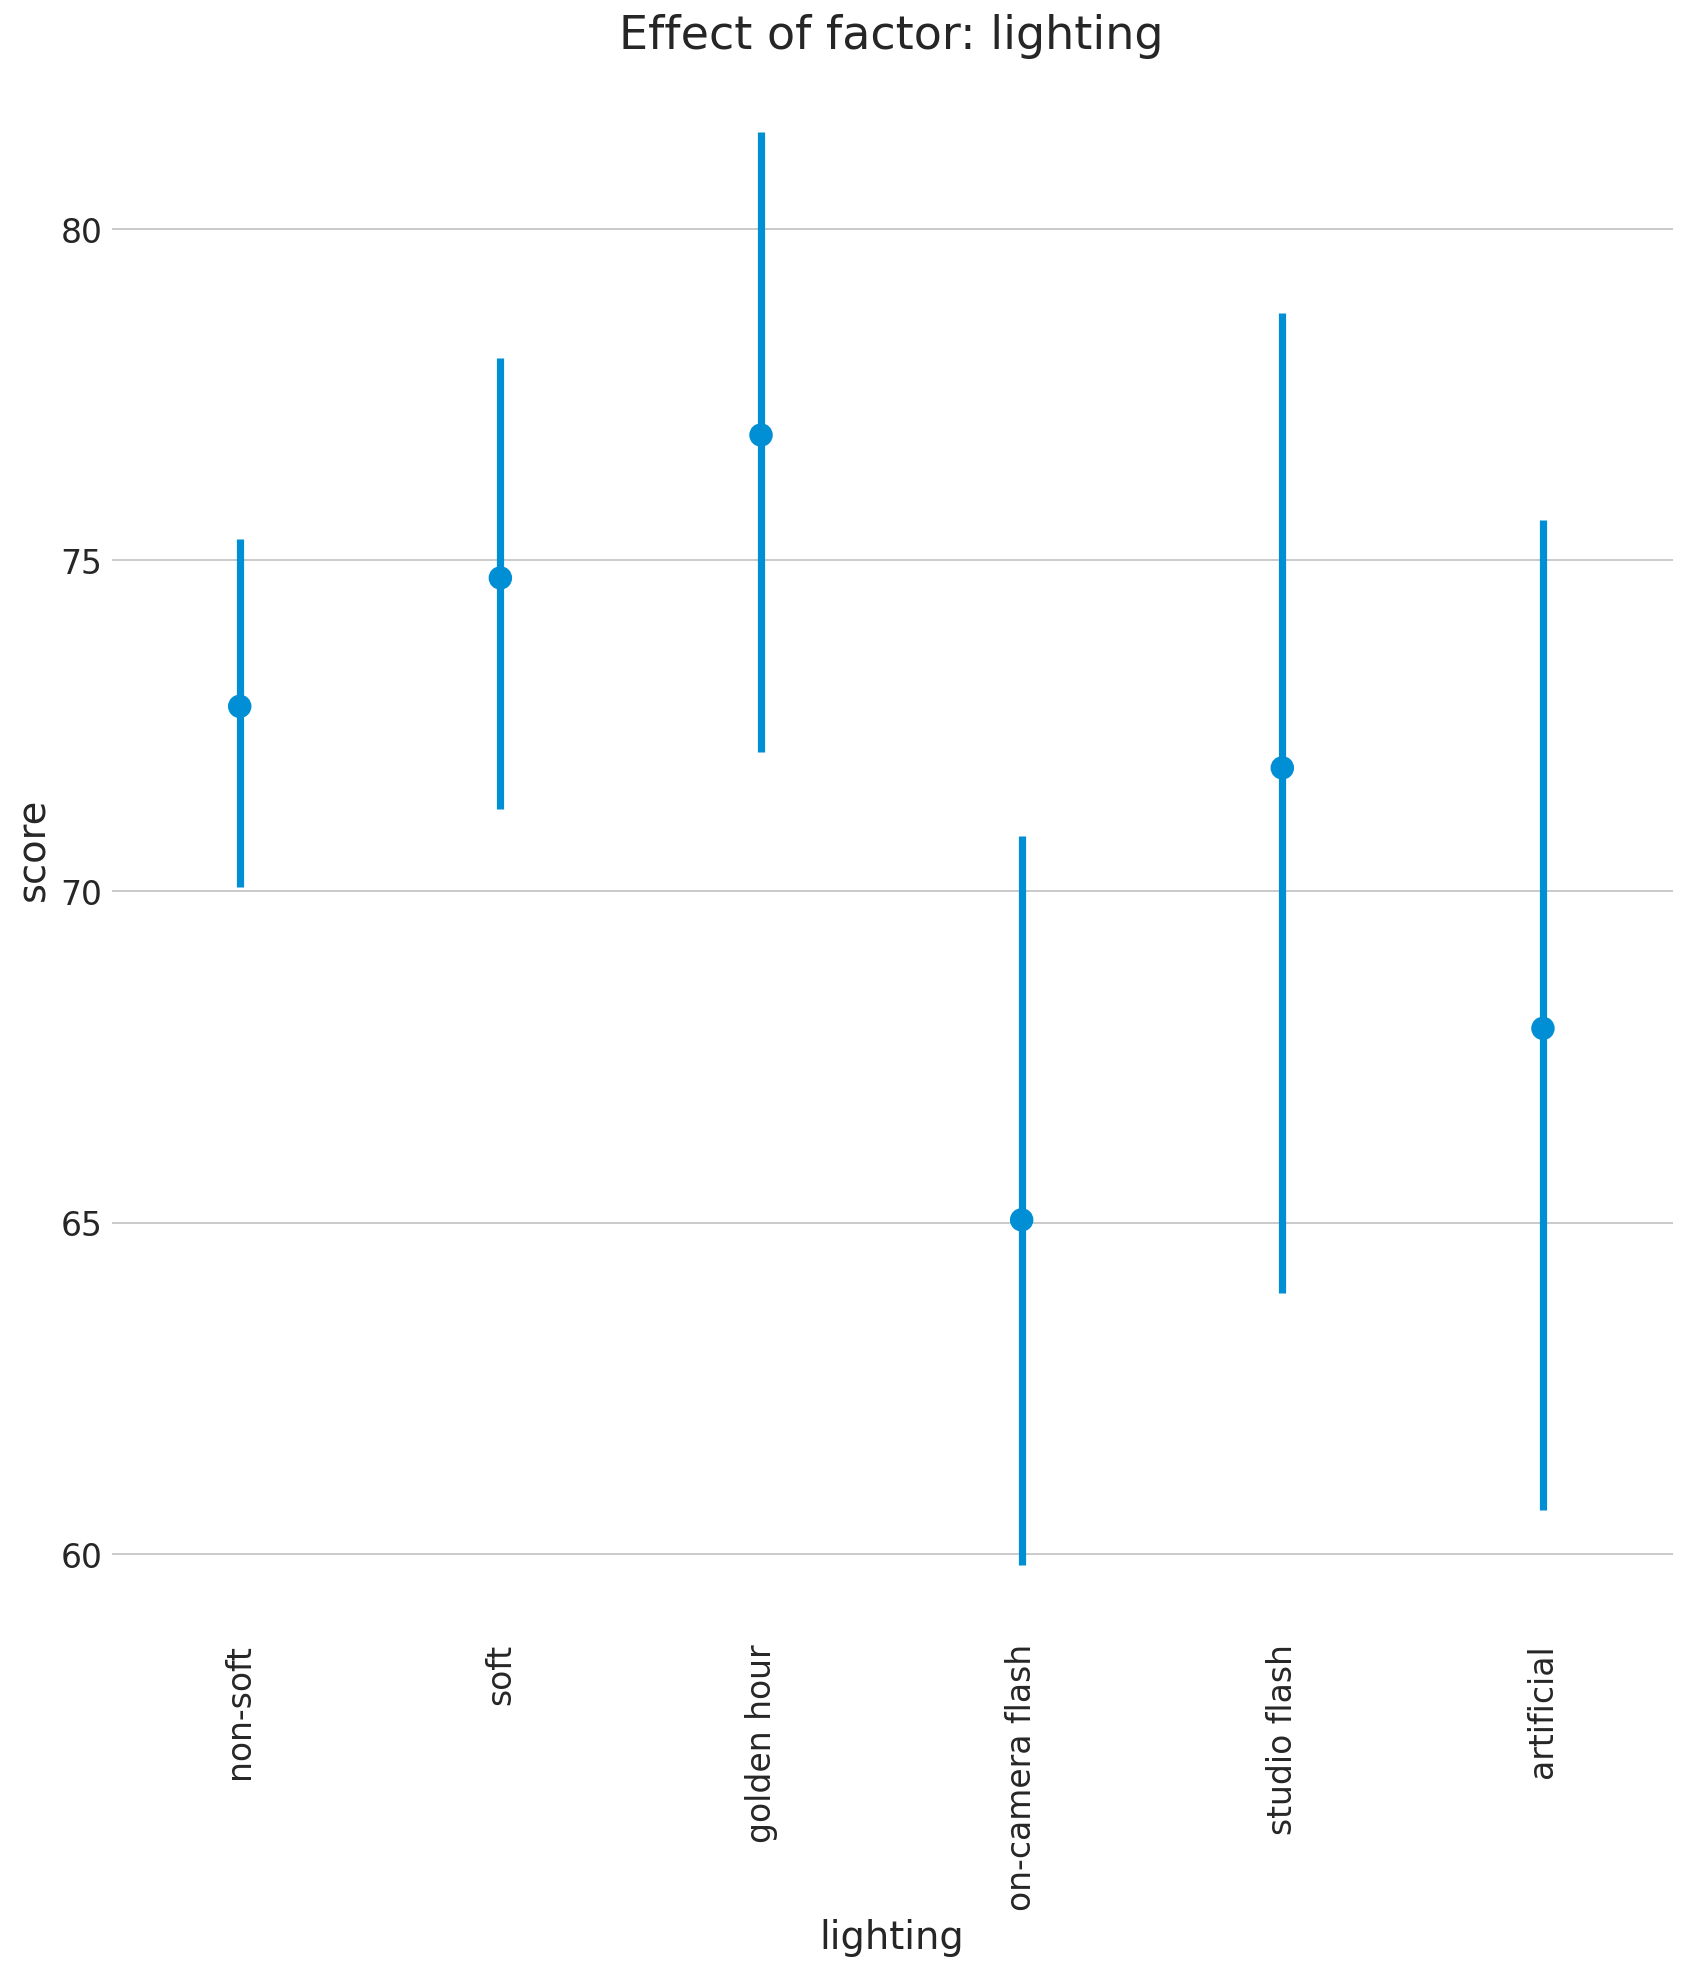

Text(0.5, 1.0, 'Effect of factor: photo_style')

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

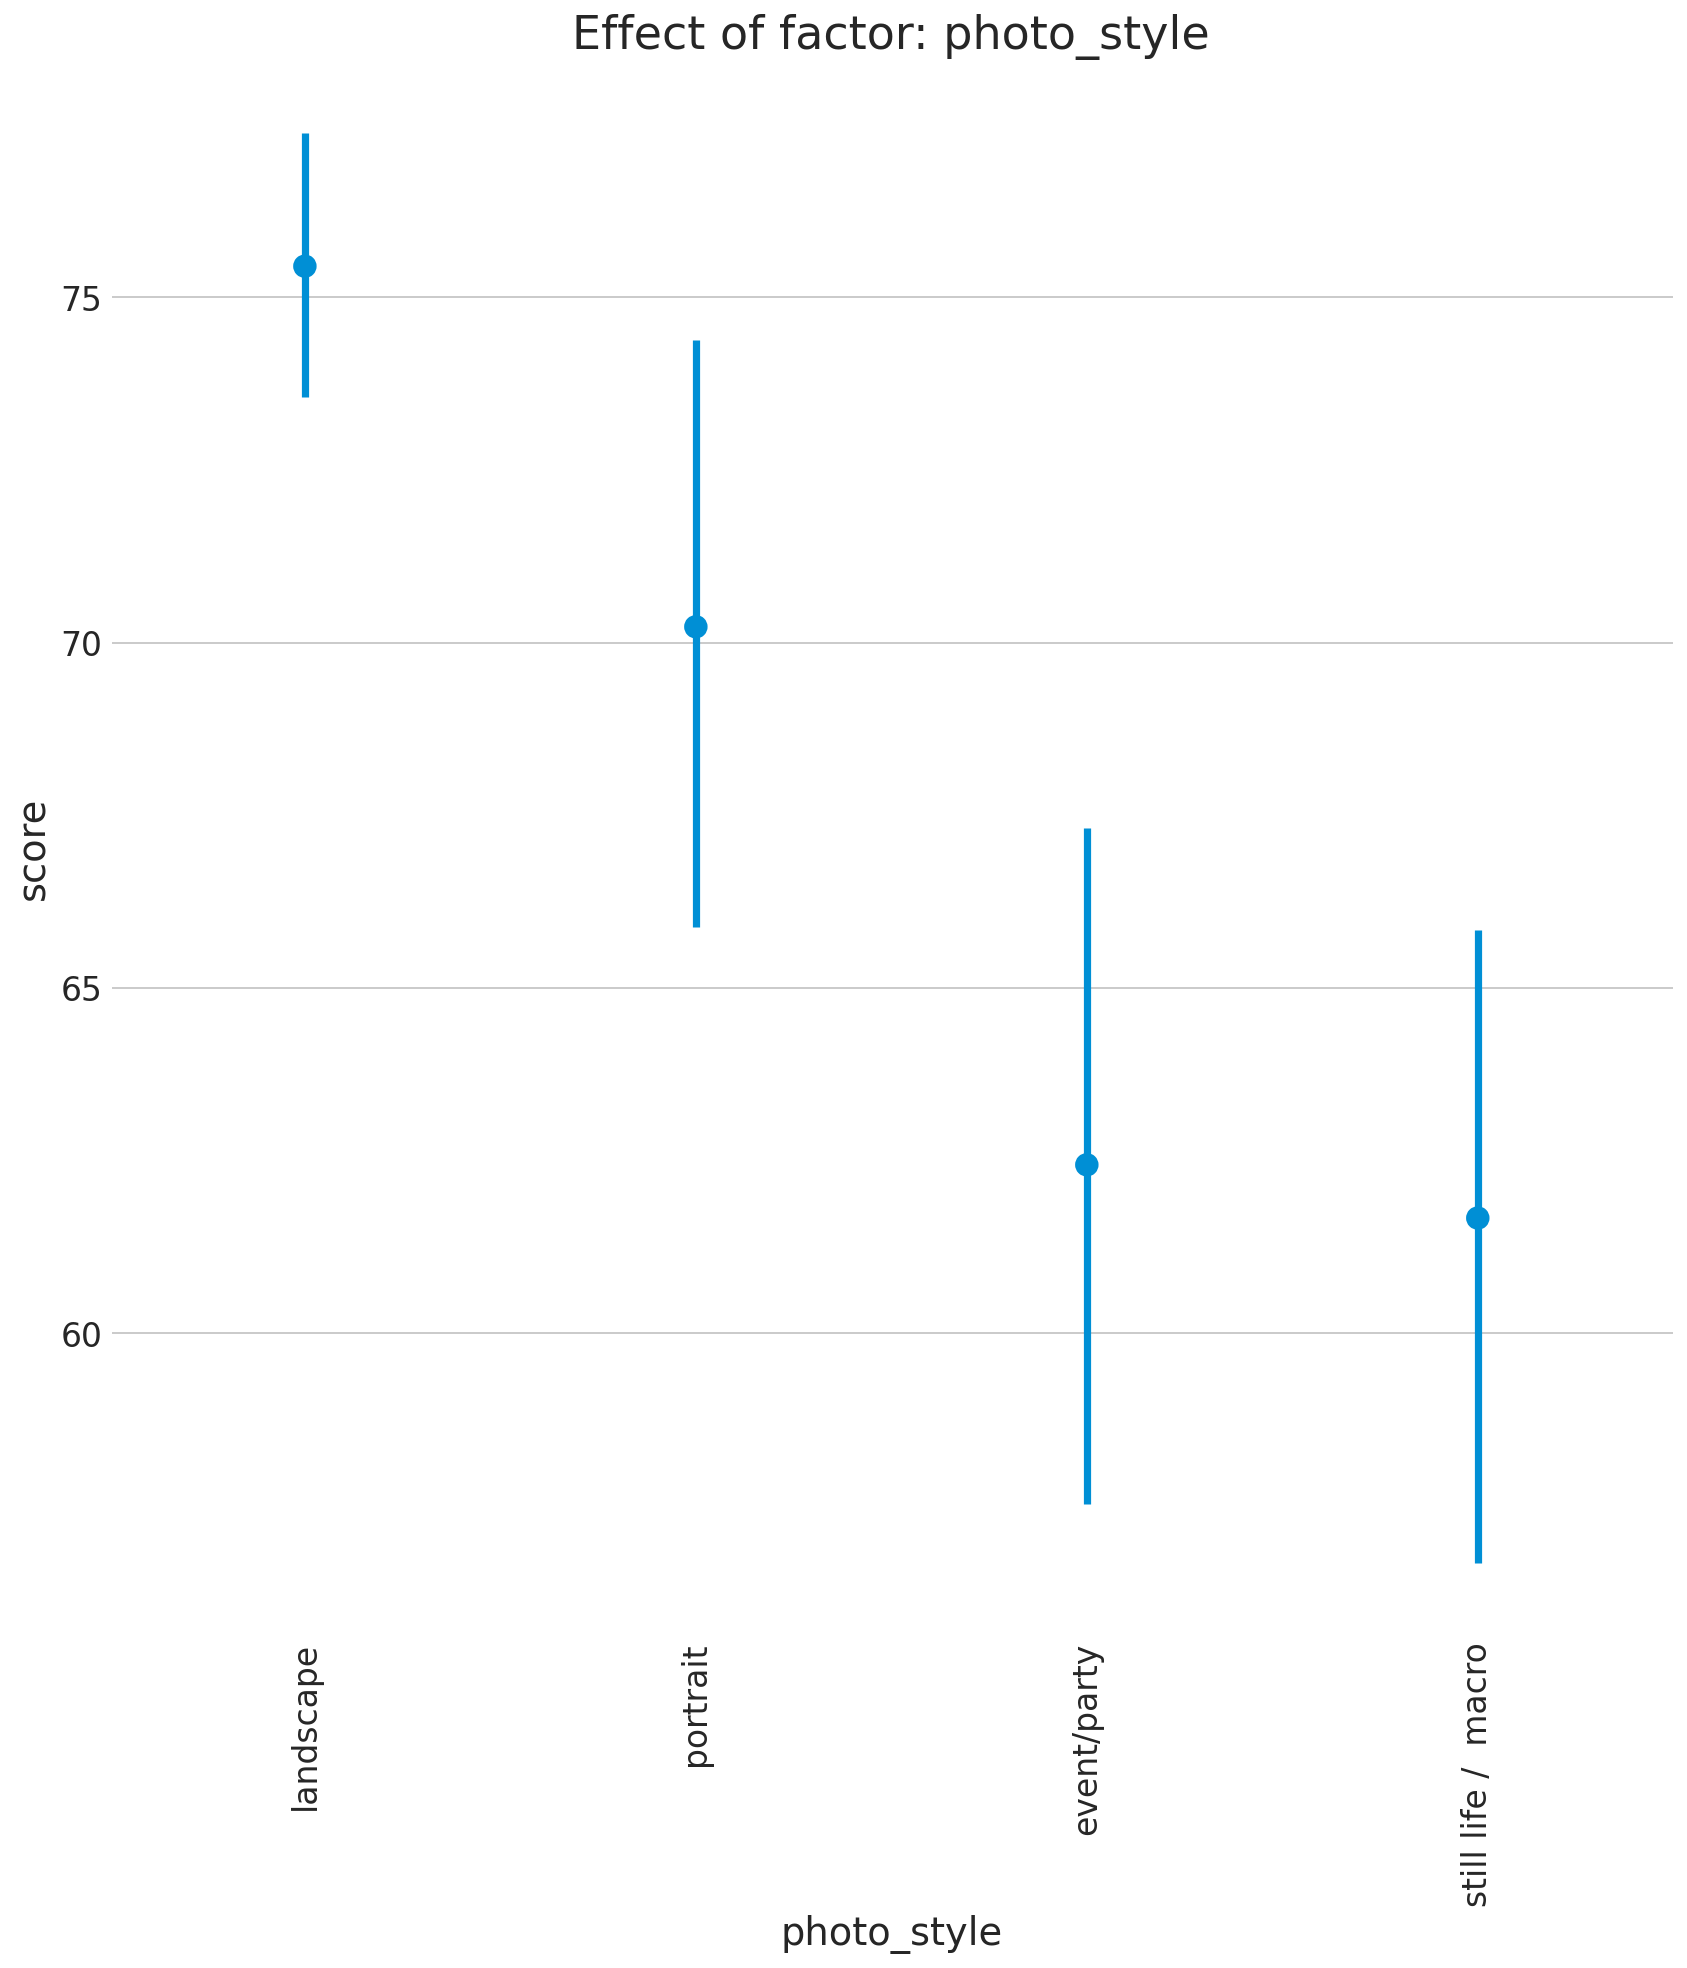

Text(0.5, 1.0, 'Effect of factor: month')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

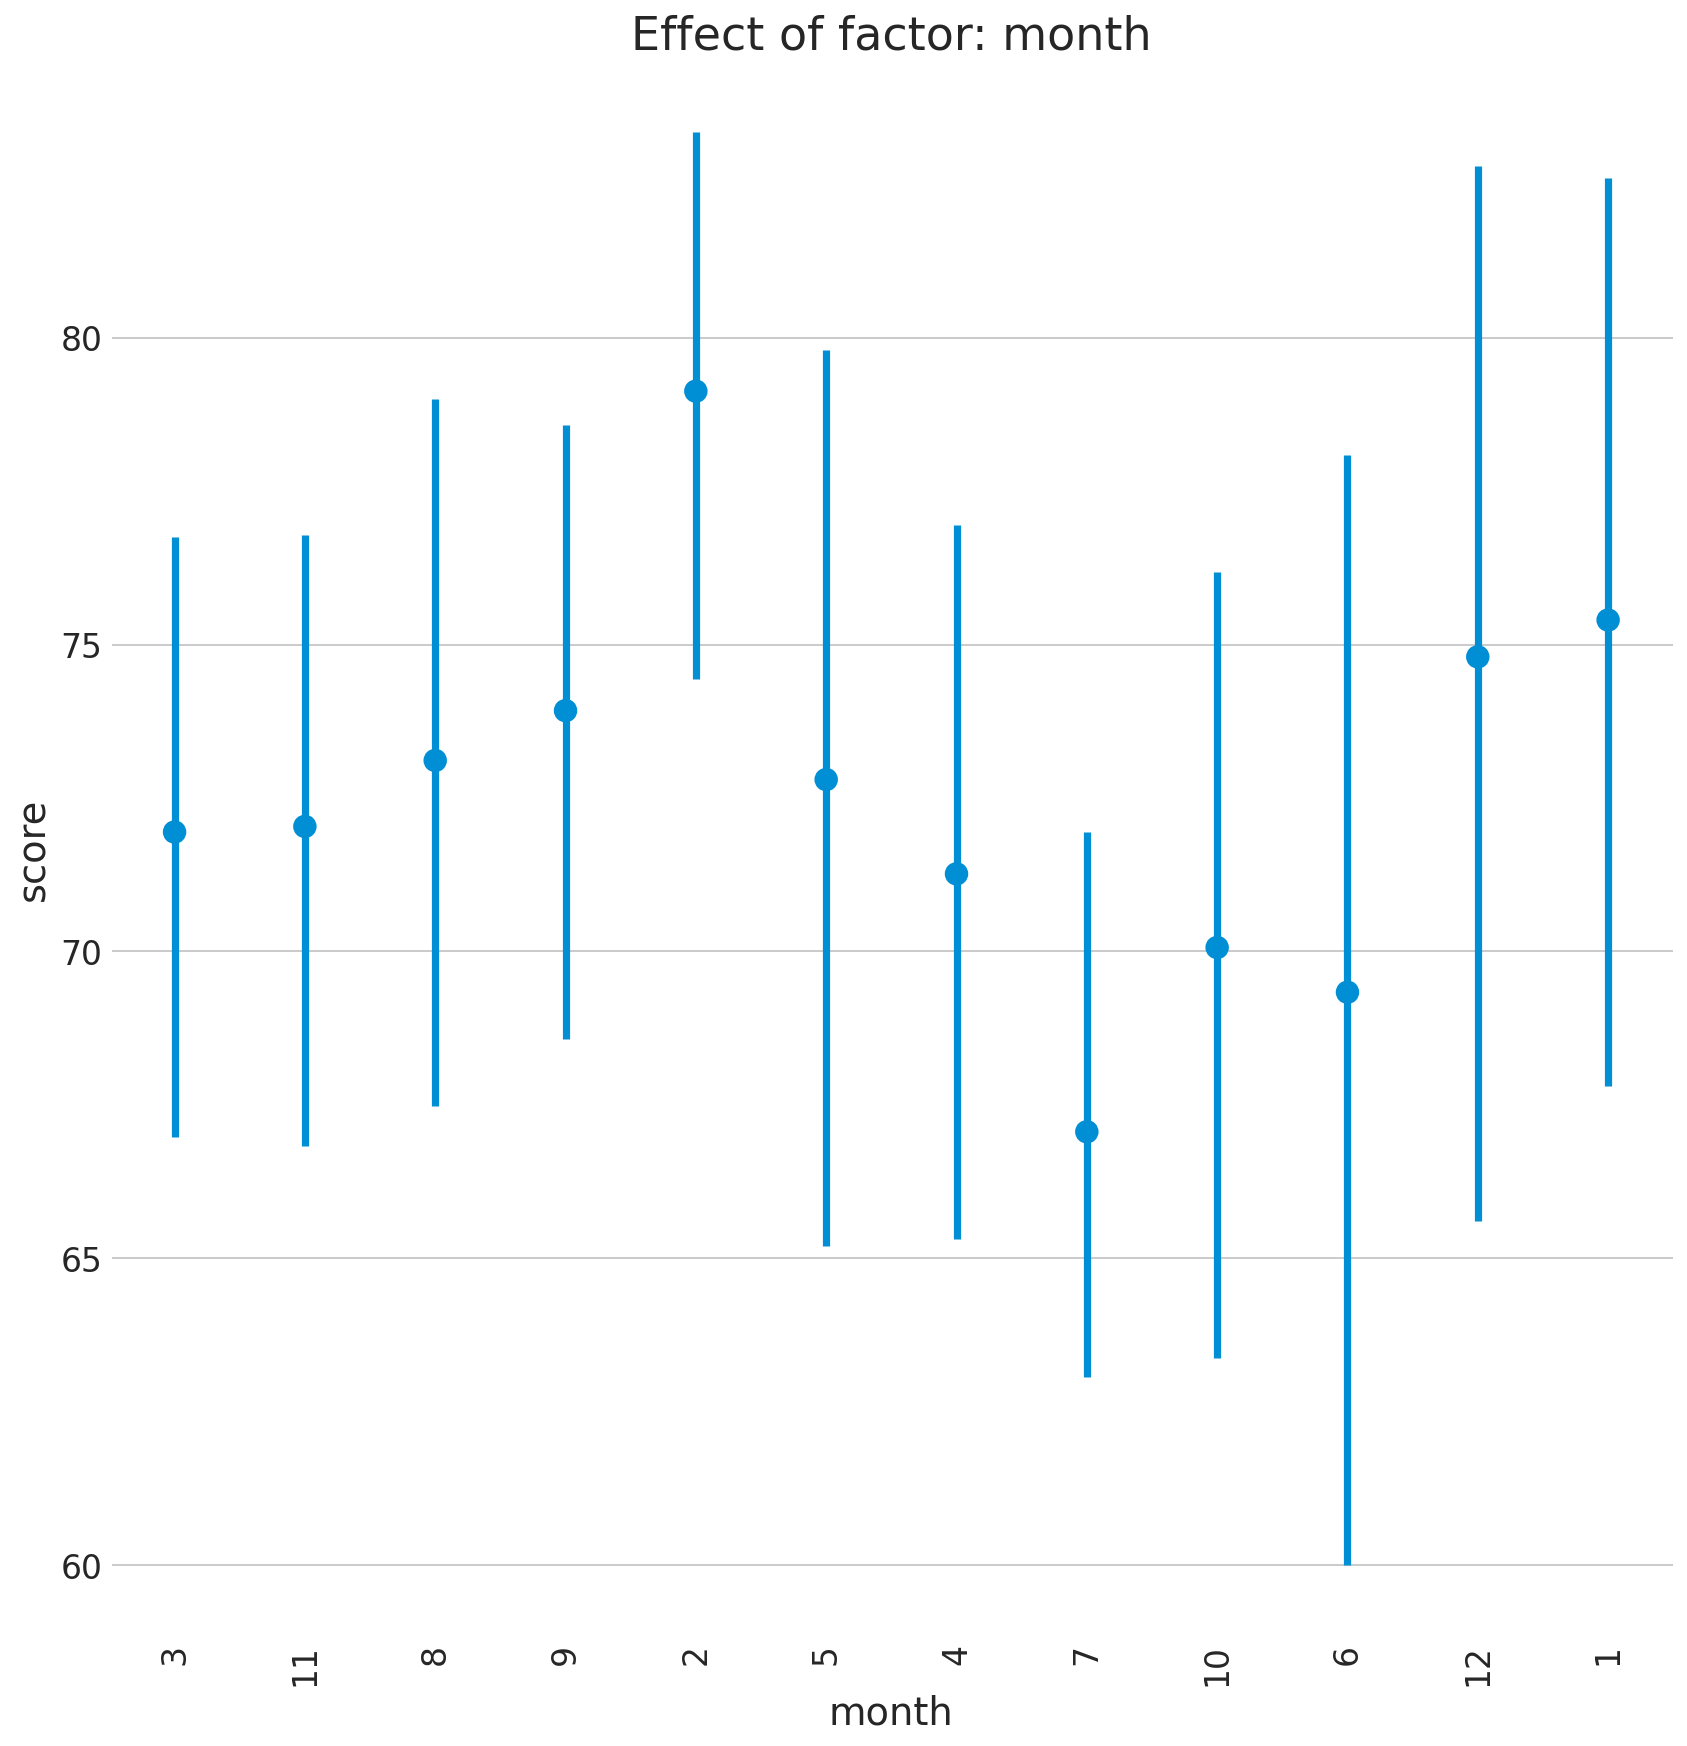

Text(0.5, 1.0, 'Effect of factor: ord_season')

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

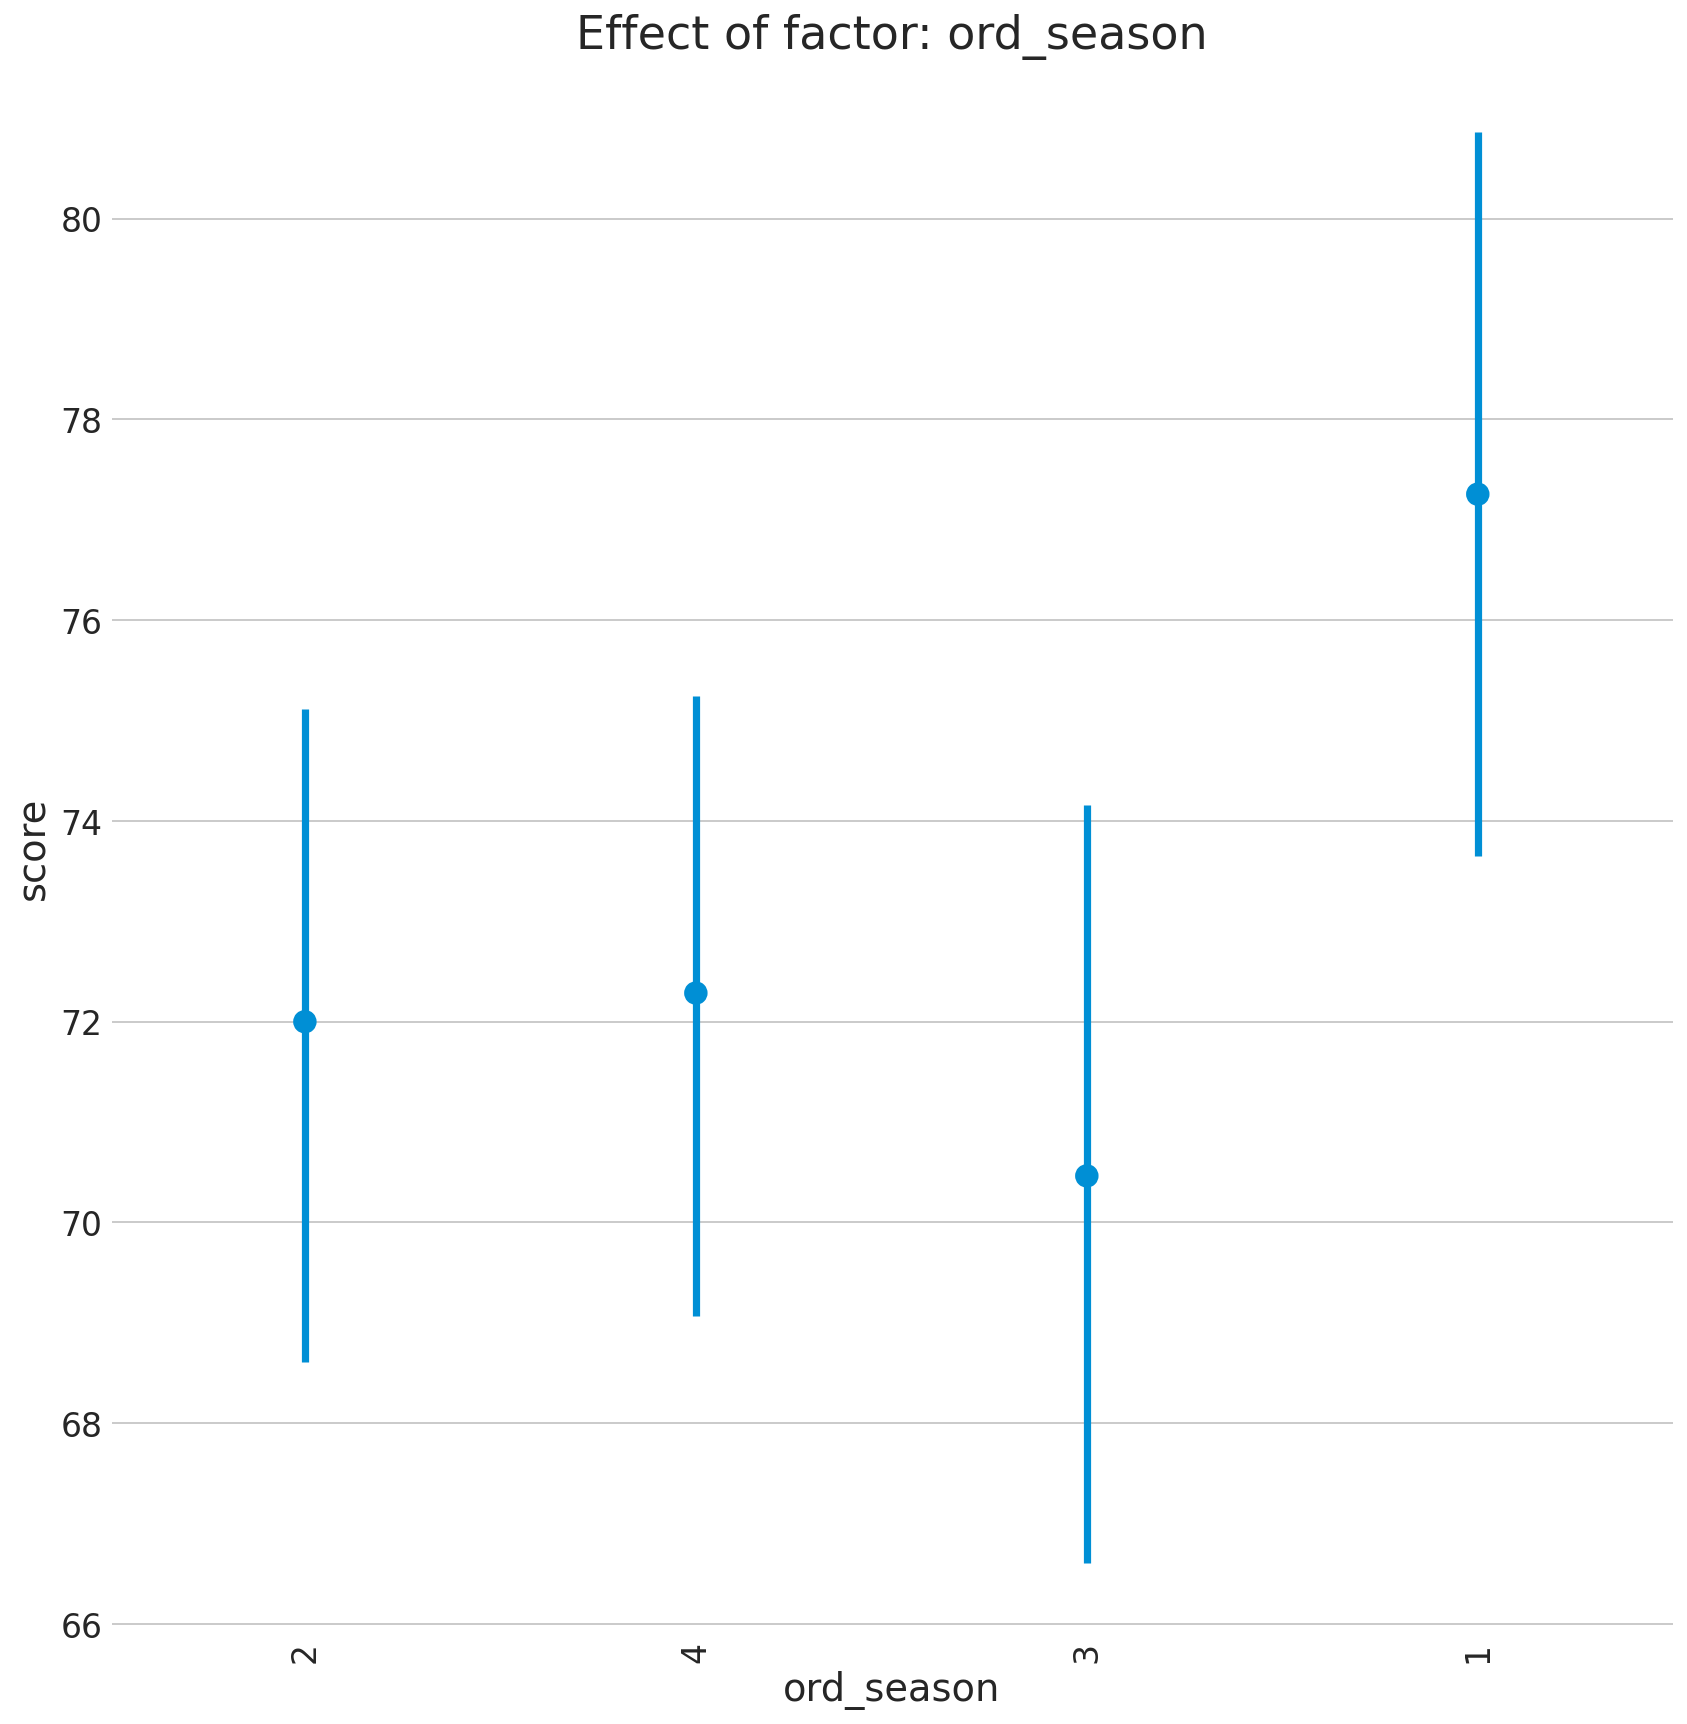

Text(0.5, 1.0, 'Effect of factor: year')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

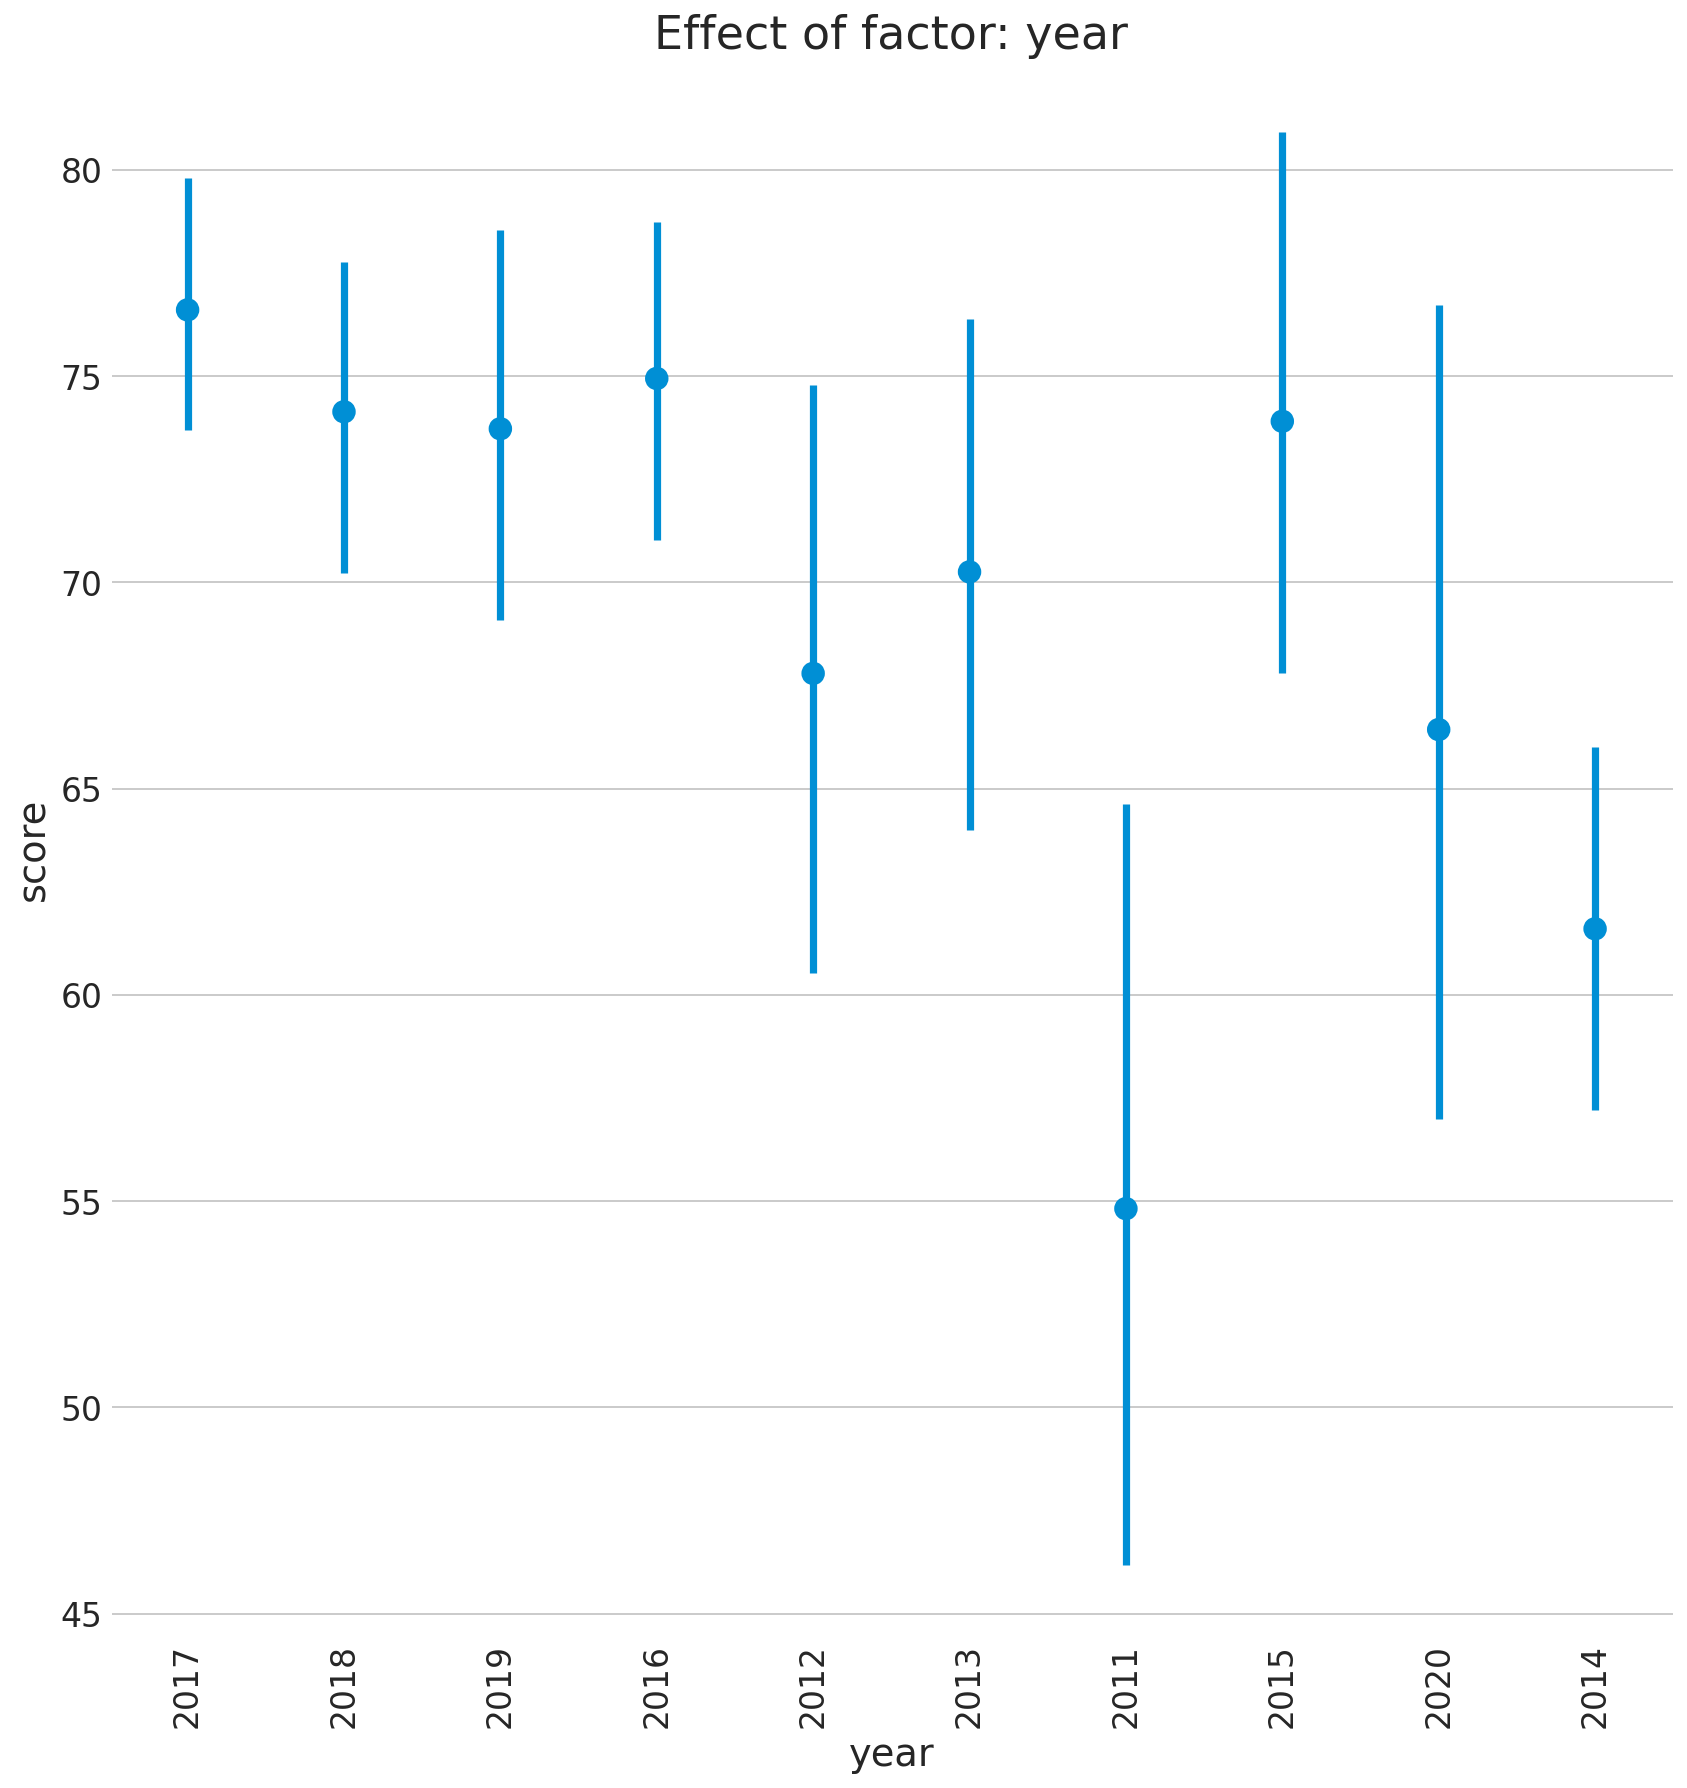

In [49]:
categorical_vars = [
    'camera',
    'camera_p_n_s',
    '35equiv_focal',
    'film_digital',
    'format',
    'shooting_circumstance',
    'filmstock',
    'lighting',
    'photo_style',
    'month',
    'ord_season',
    'year',
]

for factor in categorical_vars:
    freqs = ratings[factor].value_counts()
    # Filter on level of var occurred 3+ times; sort by freq
    freqs = freqs.loc[freqs >= 3]
    levels_to_eval = freqs.index
    #print(levels_to_eval)
    
    sns.factorplot(
        x=factor,
        y='score',
        data=ratings,
        order=levels_to_eval,
        kind='point',
        join=False,
        height=12,
    )
    plt.title(f'Effect of factor: {factor}')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
sns.regplot(
    x='minutes_before_sunset',
    y='score',
    data=ratings.loc[ratings.shooting_circumstance != 'vacation'],  # exclude vacation where sunset est will be off
    lowess=True
    #size=12,
    #alpha=.05,
)
plt.xticks([i*60 for i in range(-8,21)], rotation=90)
plt.title(f"Effect of minutes before sunset on photo ratings")
plt.show()

ratings['hour_before_sunset'] = (ratings.minutes_before_sunset <= 60) & (ratings.minutes_before_sunset >= -30)

sns.catplot(
    x='hour_before_sunset',
    y='score',
    data=ratings.loc[ratings.shooting_circumstance != 'vacation'],  # exclude vacation where sunset est will be off
    kind='point',
    join=False,
)

ratings[['date', 'taken_at', 'sunset', 'minutes_before_sunset']]

Previous rule of thumb I used was to shoot 2 hours before sunset until a bit before.

But if I go on the basis of this lowess fit (obviously no CI here, subject to error), the last hour before sunset seems better than two hours before. And after sunset is still good lighting for 30 minutes to an hour or so ("blue hour").

## Basic analyses across continuous vars

min date = 2010-11-26 10:44:00
max date = 2020-04-26 15:17:00


Text(0.5, 1.0, 'Effect of var 35equiv_focal on photo ratings')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


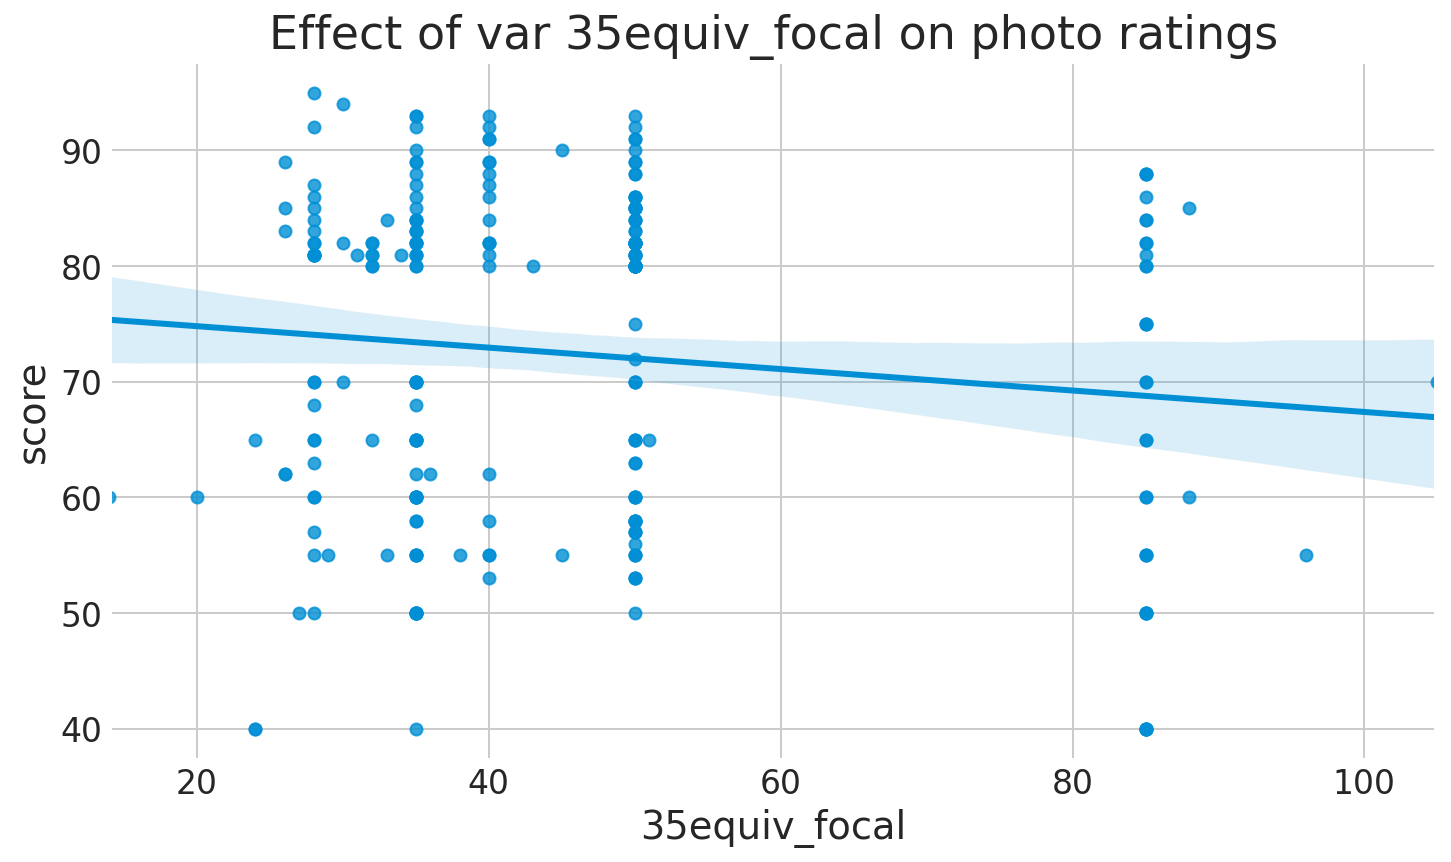

Text(0.5, 1.0, 'Effect of var 35equiv_focal on photo ratings')

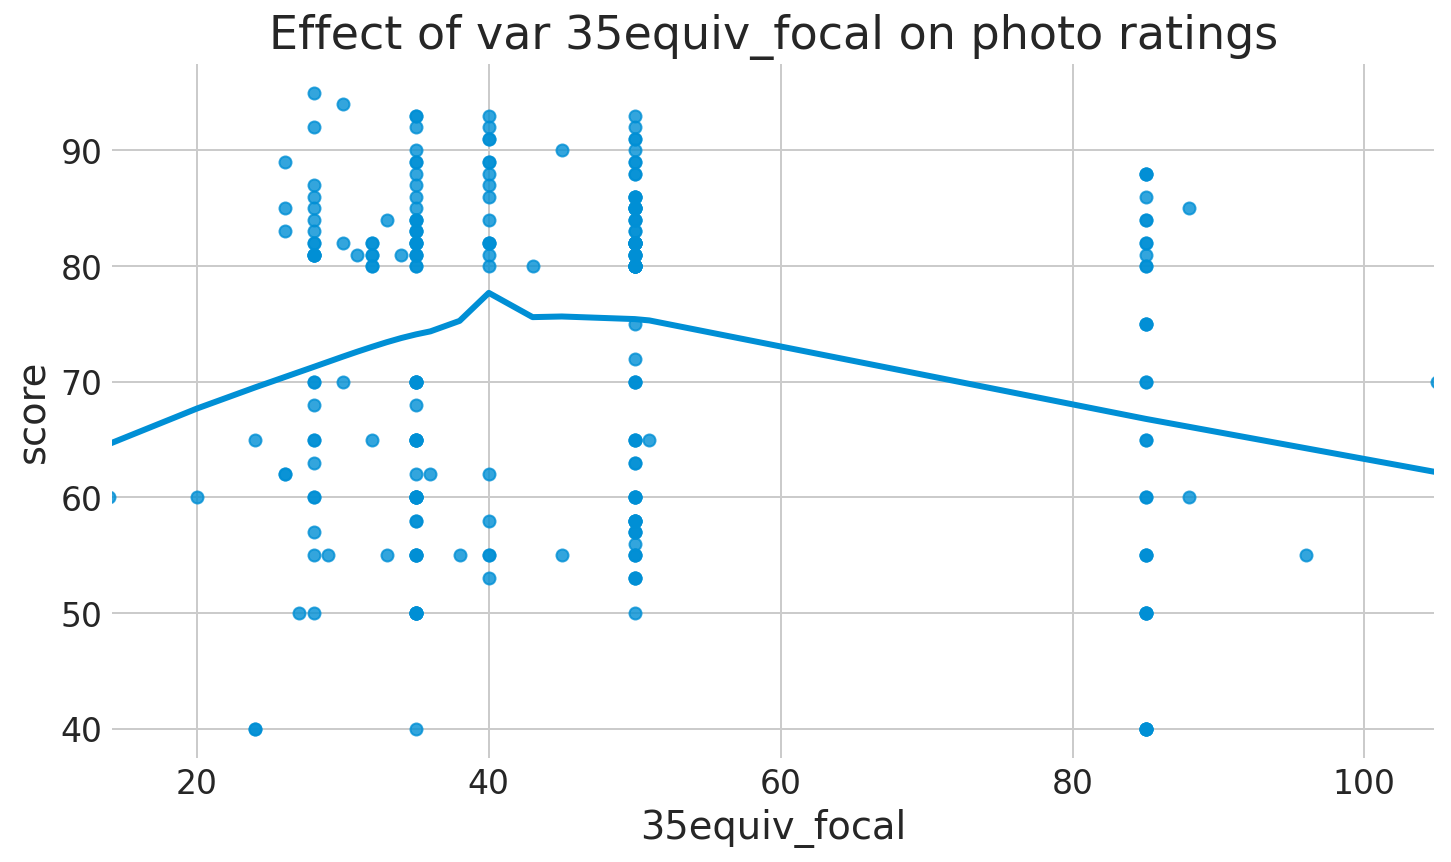

Text(0.5, 1.0, 'Effect of var date_ord on photo ratings')

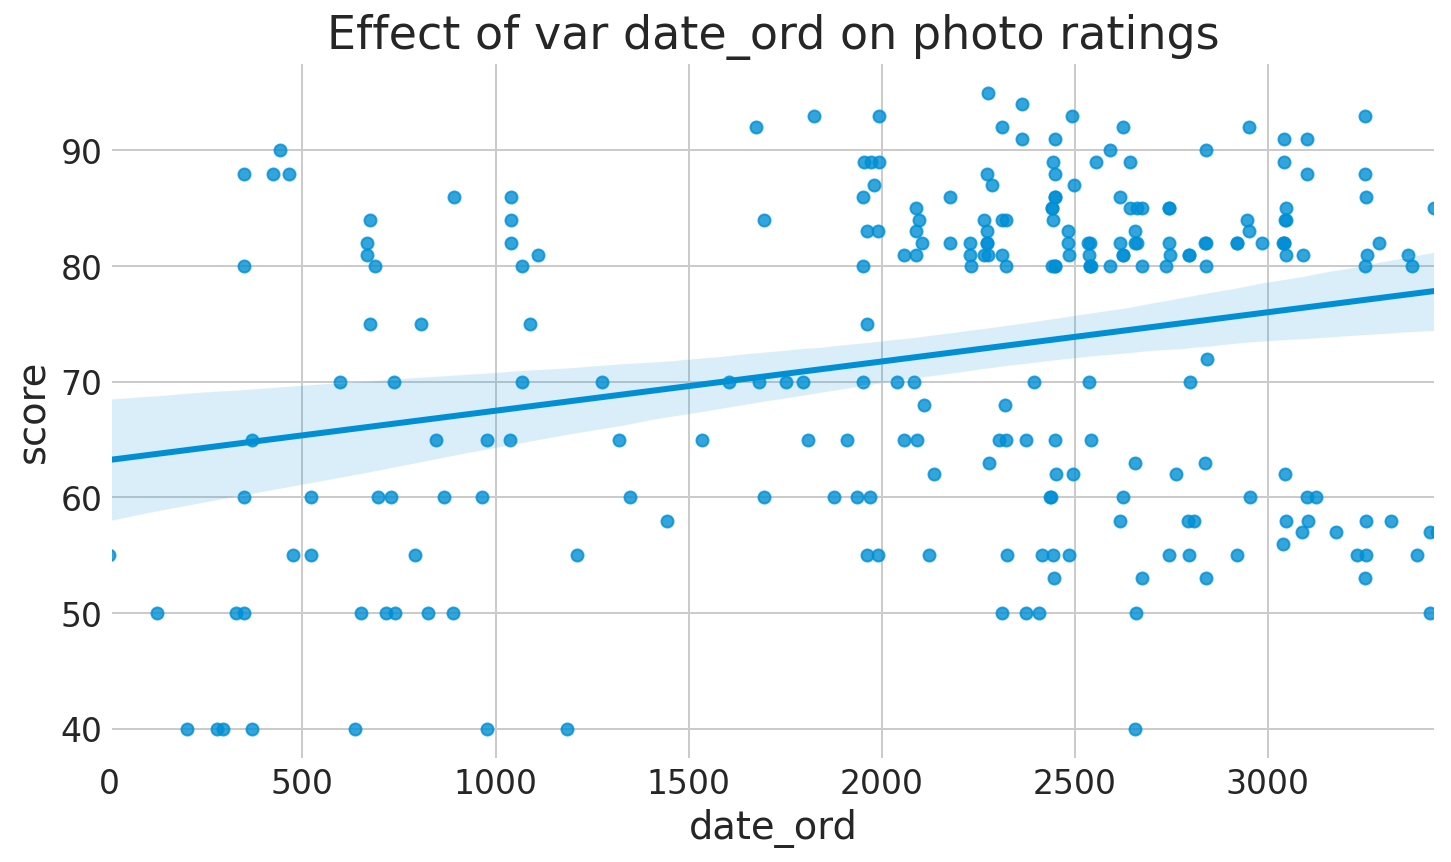

Text(0.5, 1.0, 'Effect of var date_ord on photo ratings')

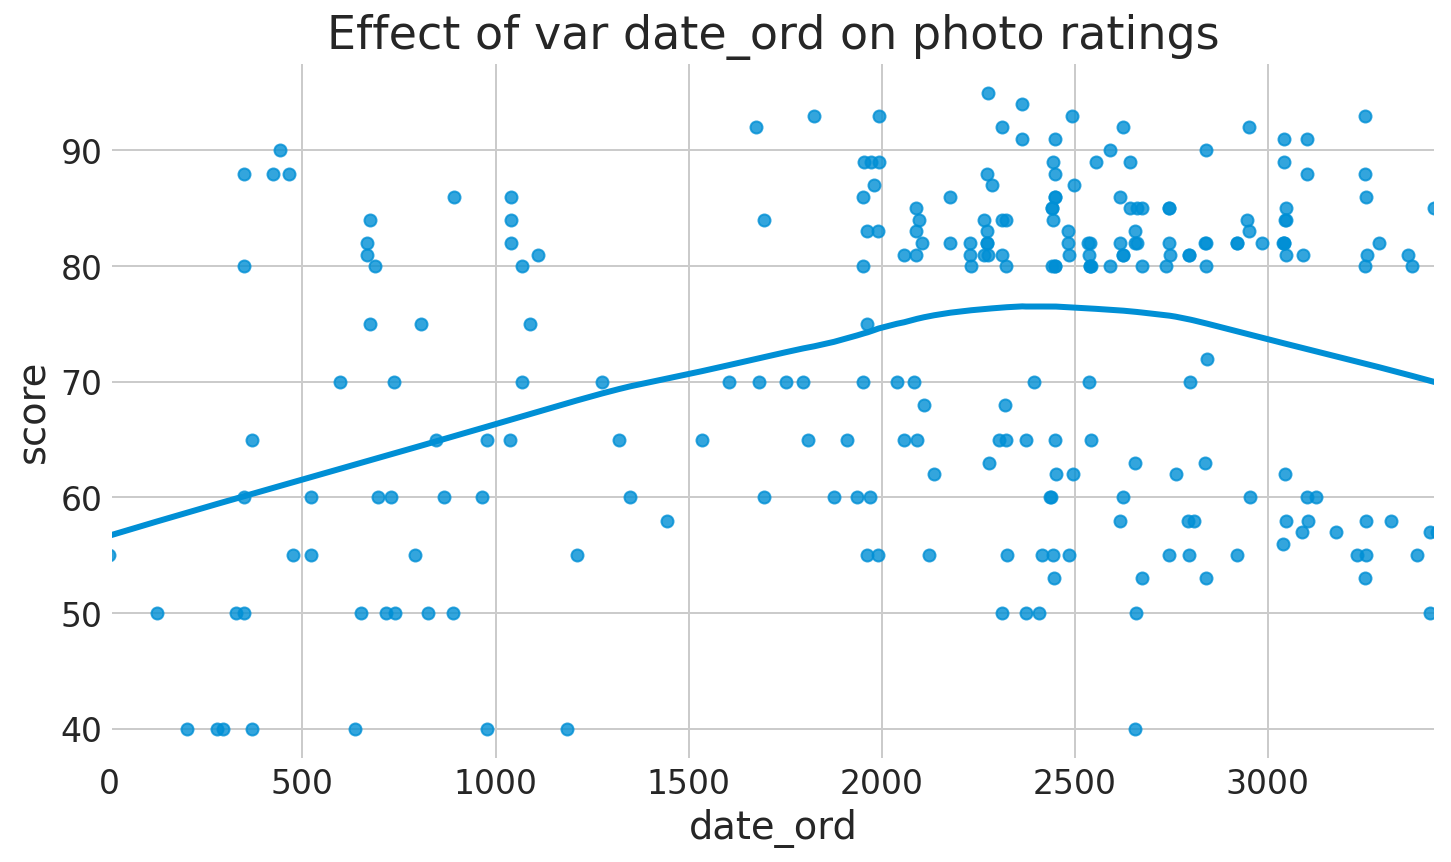

In [3]:


cts_vars = [
    '35equiv_focal',
    'date_ord',
    #'minutes_before_sunset',
]

for var in cts_vars:
    sns.regplot(
        x=var,
        y='score',
        data=ratings,
        #size=12,
        #alpha=.05,
    )
    plt.title(f"Effect of var {var} on photo ratings")
    plt.show()
    
    sns.regplot(
        x=var,
        y='score',
        data=ratings,
        lowess=True
        #size=12,
        #alpha=.05,
    )
    plt.title(f"Effect of var {var} on photo ratings")
    plt.show()


Text(0.5, 1.0, 'distribution of continuous scores')

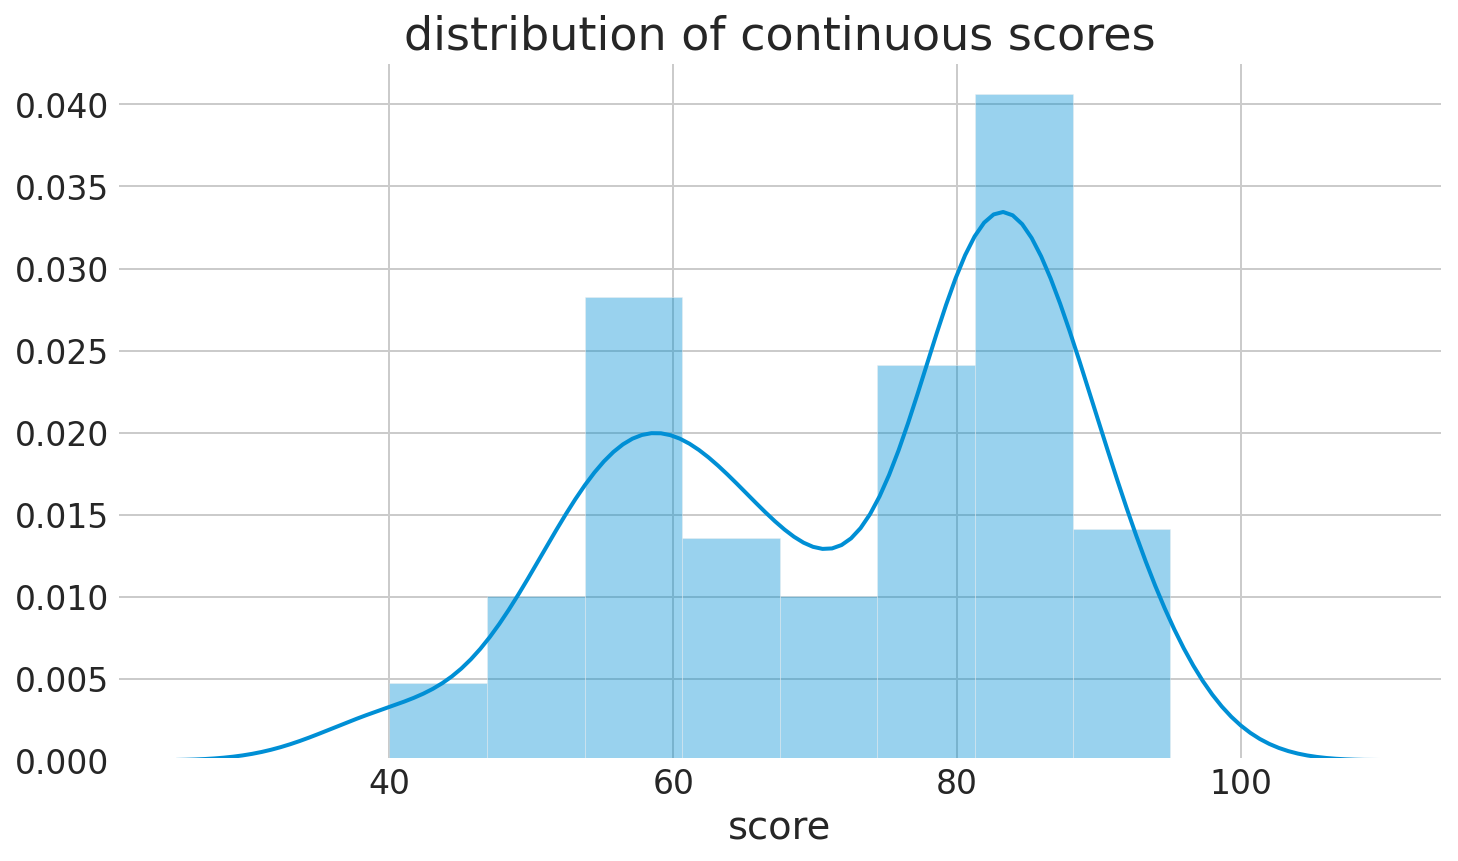

In [32]:
sns.distplot(ratings.score)
plt.title('distribution of continuous scores is bimodal / not normally distributed')
# two rating passes / sampling of "hits" and "other photos" independently


__would be good to figure out a way to deal with score bimodality__  
unfortunately hard to avoid given that I'm sampling from two diff classes in some sense.  
could also treat as clf rather than regression, but I'd be giving up statistical power.

### Basic Frequentist Regression

In [88]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

ratings['fl'] = ratings['35equiv_focal'].copy()
formula = 'score ~ photo_style + camera_p_n_s +lighting + hour_before_sunset + shooting_circumstance + format + film_digital + date_ord + fl'

mod = smf.ols(
    formula=formula, 
    data=ratings,
)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2.523
Date:                Sun, 10 May 2020   Prob (F-statistic):           0.000344
Time:                        11:29:31   Log-Likelihood:                -962.41
No. Observations:                 244   AIC:                             1971.
Df Residuals:                     221   BIC:                             2051.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               53.9910      8.429      6.405      0.000      37.379      70.603
photo_style[T.landscape]                13.6826      4.717      2.901      0.004       4.387      22.978
photo_style[T.portrait]                  5.8709      4.871      1.205      0.229      -3.728      15.470
photo_style[T.still life /  macro]      -5.0321      7.302     -0.689      0.491     -19.423       9.359
lighting[T.golden hour]                  3.0233      4.600      0.657      0.512      -6.041      12.088
lighting[T.non-soft]                    -1.6853      4.038     -0.417      0.677      -9.644       6.273
lighting[T.on-camera flash]              9.4157      5.432      1.733      0.084      -1.289      20.121
lighting[T.soft]                         0.3680      4.129      0.089      0.929      -7.770       8.506
lighting[T.studio flash]                 0.1891      6.119      0.031      0.975     -11.870      12.248
hour_before_sunset[T.True]              -9.1680      5.275     -1.738      0.084     -19.564       1.228
shooting_circumstance[T.incidental]     -1.5480      3.368     -0.460      0.646      -8.186       5.090
shooting_circumstance[T.intentional]    -0.1112      3.208     -0.035      0.972      -6.433       6.210
shooting_circumstance[T.newspaper]      10.8582      5.877      1.847      0.066      -0.724      22.441
shooting_circumstance[T.vacation]       -2.2613      3.026     -0.747      0.456      -8.224       3.702
format[T.crop_digital]                   2.6664      4.933      0.541      0.589      -7.055      12.388
format[T.ff_digital]                    -0.0699      2.375     -0.029      0.977      -4.750       4.610
format[T.mf_digital]                     2.1927      2.684      0.817      0.415      -3.096       7.482
format[T.mf_film]                        9.8053      4.750      2.064      0.040       0.444      19.167
format[T.pano_film]                      8.2829      7.023      1.179      0.240      -5.559      22.124
film_digital[T.c41_film]                -3.2739      4.293     -0.763      0.447     -11.735       5.187
film_digital[T.digital]                  4.7892      3.202      1.496      0.136      -1.520      11.099
camera_p_n_s                            -6.6688      7.121     -0.937      0.350     -20.702       7.365
date_ord                                 0.0023      0.002      1.326      0.186      -0.001       0.006
fl                                      -0.0430      0.070     -0.616      0.538      -0.181       0.095
==============================================================================
Omnibus:                       18.103   Durbin-Watson:                   0.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.573
Skew:      

significant features: 
- type of photo: event/party, landscape, portrait  
- shooting occasion: incidental shooting (non-intentional), intentional, trend toward signif for vacation
- film format: medium-format film, pano film, trend for MF digital

In [11]:
# simplified model

mod = smf.ols(
    formula='score ~ photo_style + hour_before_sunset + format', 
    data=ratings,
)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     5.590
Date:                Sat, 09 May 2020   Prob (F-statistic):           5.44e-07
Time:                        22:41:37   Log-Likelihood:                -965.99
No. Observations:                 244   AIC:                             1952.
Df Residuals:                     234   BIC:                             1987.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             56.9537      4.542     12.539      0.000      48.005      65.902
photo_style[T.landscape]              10.8801      2.934      3.708      0.000       5.099      16.661
photo_style[T.portrait]                5.9768      3.546      1.686      0.093      -1.009      12.963
photo_style[T.still life /  macro]    -1.5297      5.973     -0.256      0.798     -13.297      10.237
hour_before_sunset[T.True]             8.7112      2.736      3.183      0.002       3.320      14.102
format[T.crop_digital]                 4.1805      4.668      0.896      0.371      -5.015      13.376
format[T.ff_digital]                   6.2428      3.716      1.680      0.094      -1.078      13.563
format[T.mf_digital]                   7.7172      3.961      1.948      0.053      -0.086      15.521
format[T.mf_film]                      9.6019      4.222      2.274      0.024       1.283      17.921
format[T.pano_film]                    4.5481      6.031      0.754      0.452      -7.335      16.431
==============================================================================
Omnibus:                       15.431   Durbin-Watson:                   0.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.326
Skew:                          -0.325   Prob(JB):                      0.00944
Kurtosis:                       2.297   Cond. No.                         15.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## honestly, not sure how much value we'll get from a bayesian model, but sure, why not

- use above filtering to inform model; this is obviously problematic and will make results seem more signif

In [22]:
ratings.score.mean()

72.65573770491804

In [23]:
MCMC_SAMPLES = 10000
TUNE_ITERS = 2000
FEATS = [
    'photo_style', 
    'hour_before_sunset',
    #'shooting_circumstance',
    'format',
]
import category_encoders as ce

In [24]:
import category_encoders as ce

ohe = ce.OneHotEncoder(
    use_cat_names=True,
)

xs = ratings[FEATS].copy()
xs = ohe.fit_transform(xs).astype('float32')
xs.head()
labels = xs.columns.tolist()


with pm.Model() as model: 
    # Mildly informative priors
    priors = {
        f'{feat}': pm.StudentT.dist(sd=50, mu=0, nu=5) for i, feat in enumerate(xs.columns.tolist())  # nu is df
    }
    # I'm going to nudge the intercept toward the mean rating to make results more interpretable.
    priors['Intercept'] = pm.StudentT.dist(mu=ratings.score.mean(), sd=50, nu=5)
    #priors['lam'] = pm.HalfStudentT.dist(sd=50, mu=0, nu=3)

    family = pm.glm.families.StudentT()

    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.linear.GLM(
        x=xs.values,
        y=ratings['score'].values,
        labels=labels,  # 'labels' as in names, not y var
        family=family,
        priors=priors,
    )
    trace = pm.sample(
        MCMC_SAMPLES,
        tune=TUNE_ITERS,
        nuts_kwargs={'max_treedepth': 14}, 
        random_seed=42,
        target_accept=.85
    )

photo_style_event/party  photo_style_portrait  photo_style_landscape  photo_style_still life /  macro  hour_before_sunset  \
0                      1.0                   0.0                    0.0                              0.0                 0.0   
1                      1.0                   0.0                    0.0                              0.0                 0.0   
2                      1.0                   0.0                    0.0                              0.0                 0.0   
3                      0.0                   1.0                    0.0                              0.0                 0.0   
4                      0.0                   1.0                    0.0                              0.0                 0.0   

   format_ff_digital  format_crop_digital  format_mf_film  format_35mm_film  format_mf_digital  format_pano_film  
0                1.0                  0.0             0.0               0.0                0.0               0.0  
1                1.0                  0.0             0.0               0.0                0.0               0.0  
2                1.0                  0.0             0.0               0.0                0.0               0.0  
3                1.0                  0.0             0.0               0.0                0.0               0.0  
4                1.0                  0.0             0.0               0.0                0.0               0.0

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, format_pano_film, format_mf_digital, format_35mm_film, format_mf_film, format_crop_digital, format_ff_digital, hour_before_sunset, photo_style_still life /  macro, photo_style_landscape, photo_style_portrait, photo_style_event/party, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 48000/48000 [07:32<00:00, 106.14draws/s]
The number of effective samples is smaller than 25% for some parameters.


mean      sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat
Intercept                        68.306  26.366  18.941  118.395      0.261    0.185   10208.0  10208.0   10190.0   13257.0    1.0
photo_style_event/party         -11.680  22.265 -52.822   30.985      0.216    0.159   10604.0   9746.0   10605.0   12822.0    1.0
photo_style_portrait              4.961  22.290 -36.338   47.872      0.216    0.164   10649.0   9268.0   10655.0   12678.0    1.0
photo_style_landscape            11.090  22.188 -30.897   52.643      0.216    0.162   10576.0   9406.0   10579.0   12639.0    1.0
photo_style_still life /  macro  -6.985  22.327 -48.249   35.564      0.216    0.161   10714.0   9559.0   10720.0   12990.0    1.0
hour_before_sunset                5.676   2.032   1.766    9.430      0.013    0.009   24630.0  23527.0   24603.0   21300.0    1.0
format_ff_digital                 1.264  18.157 -32.391   36.267      0.191    0.135    9001.0   9001.0    8997.0   10837.0    1.0
format_crop_digital               0.806  18.397 -34.925   34.886      0.192    0.136    9151.0   9151.0    9150.0   11431.0    1.0
format_mf_film                    2.845  18.189 -32.413   36.198      0.191    0.135    9036.0   9036.0    9032.0   11161.0    1.0
format_35mm_film                 -8.075  18.664 -43.493   26.712      0.192    0.136    9436.0   9436.0    9438.0   12738.0    1.0
format_mf_digital                 1.653  18.196 -33.044   35.811      0.192    0.136    9002.0   9002.0    8998.0   10785.0    1.0
format_pano_film                 -1.668  18.488 -37.091   32.740      0.193    0.136    9206.0   9206.0    9203.0   12309.0    1.0
lam                               0.023   0.005   0.015    0.031      0.000    0.000   23112.0  21681.0   24351.0   20583.0    1.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f230e29c7f0>,
      dtype=object)

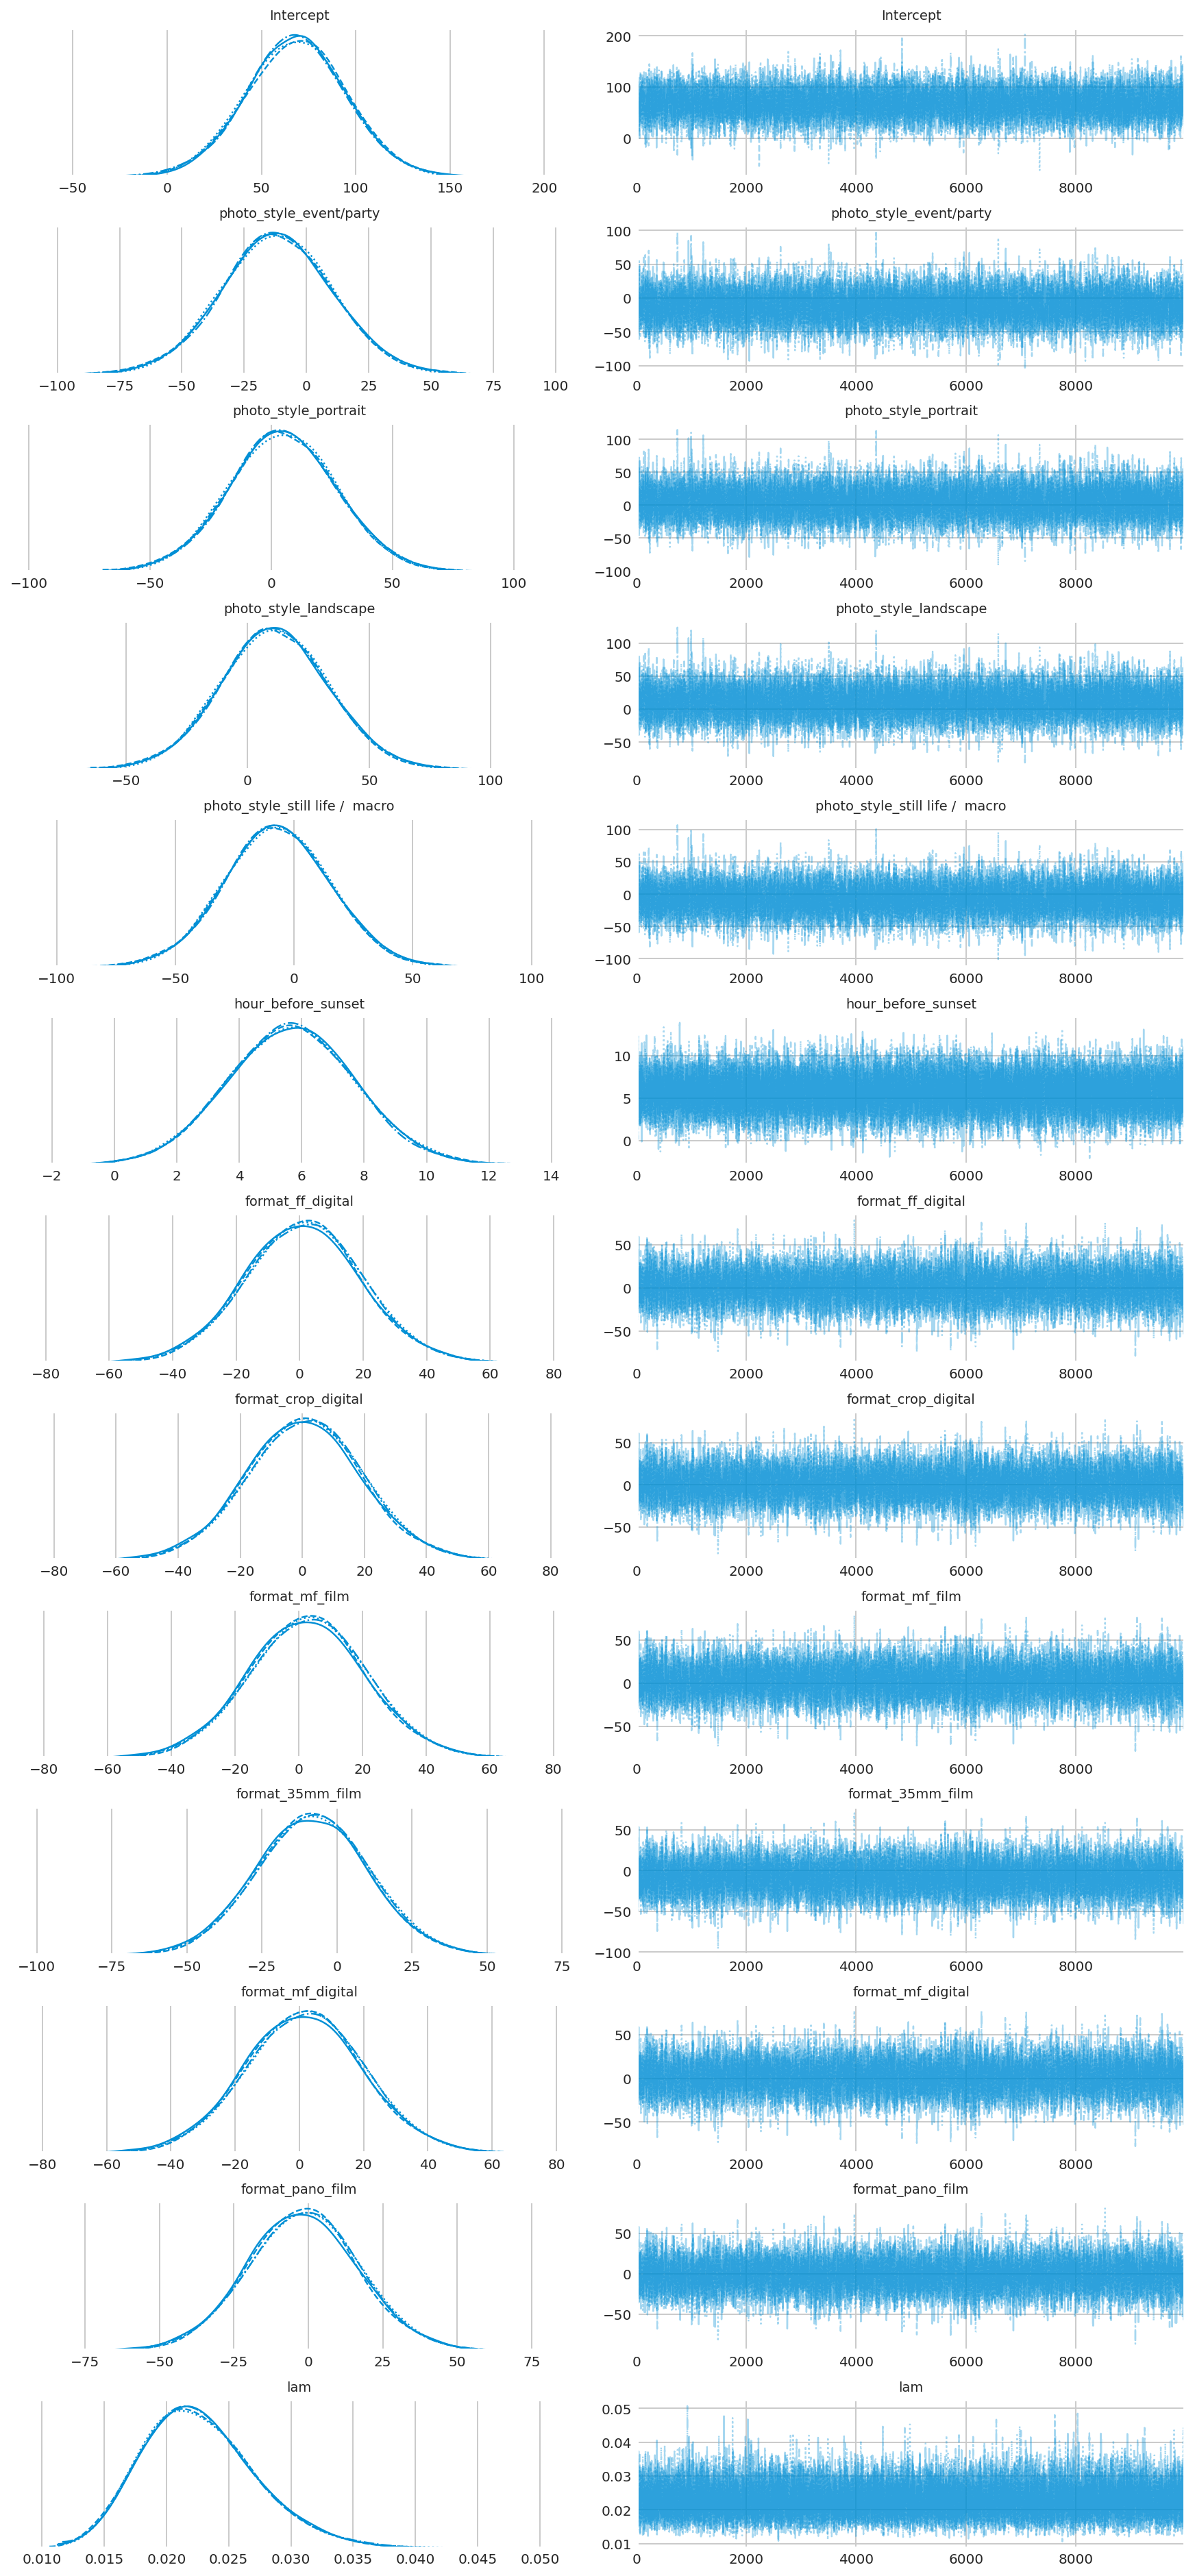

In [25]:
pm.summary(trace).round(4)

pm.traceplot(trace)
plt.show()

/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/arviz/plots/plot_utils.py:653: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (52) in plot_autocorr, generating only 40 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f22fe6ccc18>,
      dtype=object)

<Figure size 864x576 with 0 Axes>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f230e139908>],
      dtype=object)

<Figure size 864x576 with 0 Axes>

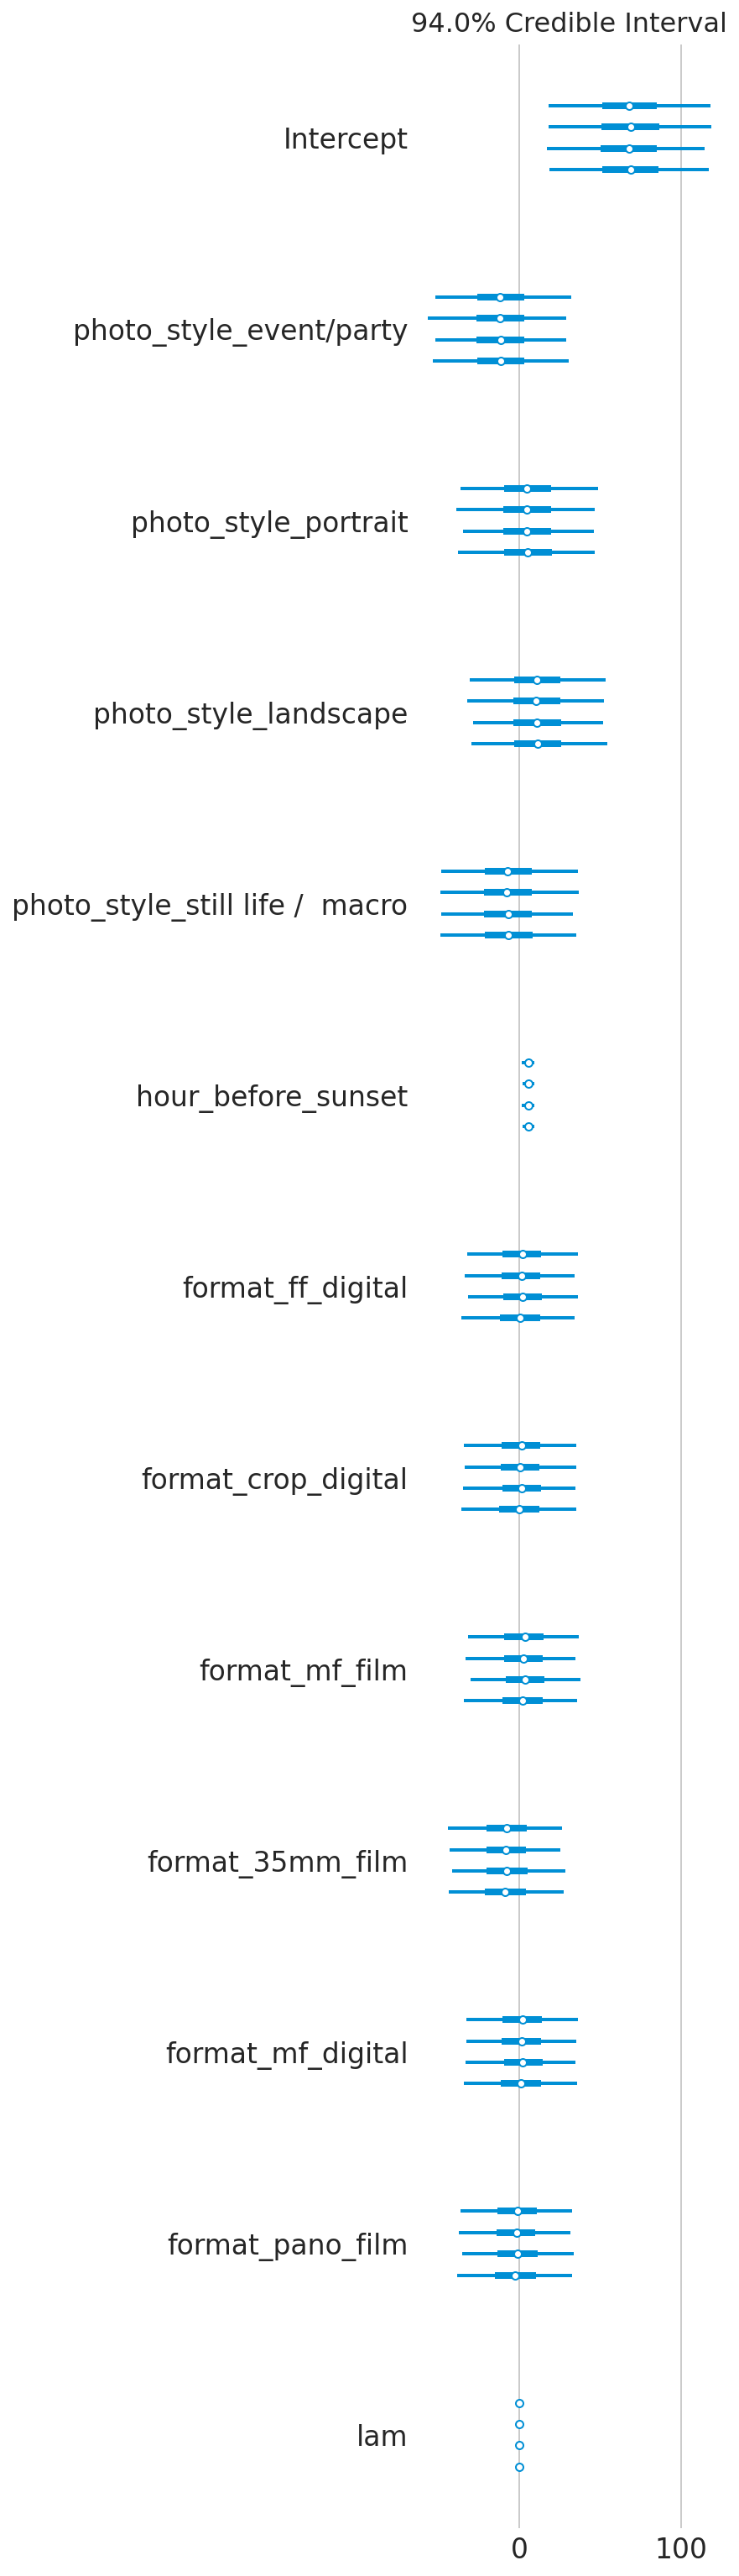

In [26]:
pm.autocorrplot(trace)
plt.show()

plt.figure(figsize=(12,8))
pm.forestplot(trace)
plt.show()

- this is to say we can't learn very much ;)  
- just take some photos and don't worry about your gear?  

## Treat this as a classification problem

In [27]:
ratings_clf = ratings.loc[((ratings.rating >= 2) | (ratings.rating == 0))]

ratings_clf

photo_description        date   time   camera  35equiv_focal film_digital      format  \
0                            man with a megaphone  2011/11/09  13:41       5d             85      digital  ff_digital   
1                          police officer praying  2011/11/09  15:47       5d             85      digital  ff_digital   
2                 man playing guitar with streaks  2012/01/22  21:54       5d             85      digital  ff_digital   
3    man holding a football with upside down flag  2012/03/04  10:56       5d             85      digital  ff_digital   
4            football player with horizontal ball  2012/09/23  17:47       5d             85      digital  ff_digital   
..                                            ...         ...    ...      ...            ...          ...         ...   
242            24000: plant at huntington library  2019/12/28  13:18      m10             50      digital  ff_digital   
243                        24217: american bag co  2020/03/04  16:12  gfx_100             40      digital  mf_digital   
244      24400: self portrait wearing ramie shirt  2020/04/07  16:55  gfx_100             50      digital  mf_digital   
245                     24600: TA w/ studio flash  2020/04/07  14:52      m10             50      digital  ff_digital   
246          24800: TA weird lean studio portrait  2020/04/26  15:17  gfx_100             50      digital  mf_digital   

    shooting_circumstance filmstock      lighting  minutes_before_sunset  photo_style  rating  score note            taken_at  month  \
0               newspaper       NaN      non-soft             203.750000  event/party     2.0     80  NaN 2011-11-09 13:41:00     11   
1               newspaper       NaN      non-soft              77.750000  event/party     2.0     88  NaN 2011-11-09 15:47:00     11   
2               newspaper       NaN    artificial            -272.750000  event/party     2.0     88  NaN 2012-01-22 21:54:00      1   
3               newspaper       NaN      non-soft             430.366667     portrait     2.0     88  NaN 2012-03-04 10:56:00      3   
4               newspaper       NaN  studio flash              79.383333     portrait     2.0     81  NaN 2012-09-23 17:47:00      9   
..                    ...       ...           ...                    ...          ...     ...    ...  ...                 ...    ...   
242              vacation       NaN      non-soft            1440.000000    landscape     0.0     58  NaN 2019-12-28 13:18:00     12   
243            after_work       NaN          soft            1440.000000    landscape     0.0     55  NaN 2020-03-04 16:12:00      3   
244           intentional       NaN  studio flash                    NaN     portrait     0.0     50  NaN 2020-04-07 16:55:00      4   
245           intentional       NaN  studio flash                    NaN     portrait     0.0     57  NaN 2020-04-07 14:52:00      4   
246           intentional       NaN  studio flash                    NaN     portrait     0.0     57  NaN 2020-04-26 15:17:00      4   

     year  ord_season     date_ord                    sunset  hour_before_sunset  fl  
0    2011           4   348.122917 2011-11-09 17:04:45-08:00               False  85  
1    2011           4   348.210417 2011-11-09 17:04:45-08:00               False  85  
2    2012           1   422.465278 2012-01-22 17:21:15-08:00               False  85  
3    2012           2   464.008333 2012-03-04 18:06:22-08:00               False  85  
4    2012           4   667.293750 2012-09-23 19:06:23-07:00               False  85  
..    ...         ...          ...                       ...                 ...  ..  
242  2019           1  3319.106944 2020-04-07 19:38:12-07:00               False  50  
243  2020           2  3386.227778 2020-04-26 19:55:40-07:00               False  40  
244  2020           2  3420.257639                       NaT               False  50  
245  2020           2  3420.172222                       NaT               F

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

ratings_clf['fl'] = ratings_clf['35equiv_focal'].copy()
ratings_clf['good_photo'] = (ratings.rating >= 2).astype('int')

# normalize cts vars: date ord and focal length
ratings_clf['date_norm'] = (ratings_clf['date_ord'] - ratings_clf['date_ord'].mean()) / ratings_clf['date_ord'].std()
ratings_clf['fl_norm'] = (ratings_clf['fl'] - ratings_clf['fl'].mean()) / ratings_clf['fl'].std()

mod = smf.logit(
    formula='good_photo ~ photo_style + lighting + hour_before_sunset + shooting_circumstance + format + film_digital + date_norm + fl_norm', 
    data=ratings_clf,
)
res = mod.fit(
    maxiter=1000,
    method='bfgs',
)
# trouble converging, try adding very small amount of reg
# res = mod.fit_regularized(
#     method='l1',
#     alpha=.0001, 
#     maxiter=1000,
#     qc_verbose=True,
# )
res.summary()

Optimization terminated successfully.
         Current function value: 0.550341
         Iterations: 148
         Function evaluations: 149
         Gradient evaluations: 149


/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jan/miniconda3/envs/jan/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             good_photo   No. Observations:                  236
Model:                          Logit   Df Residuals:                      214
Method:                           MLE   Df Model:                           21
Date:                Sat, 09 May 2020   Pseudo R-squ.:                  0.2000
Time:                        23:50:21   Log-Likelihood:                -129.88
converged:                       True   LL-Null:                       -162.36
Covariance Type:            nonrobust   LLR p-value:                 2.206e-06
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -2.5929      1.313     -1.975      0.048      -5.167      -0.019
photo_style[T.landscape]                 2.3489      0.950      2.471      0.013       0.486       4.212
photo_style[T.portrait]                  0.9826      0.917      1.072      0.284      -0.814       2.779
photo_style[T.still life /  macro]     -14.8961    683.563     -0.022      0.983   -1354.654    1324.862
lighting[T.golden hour]                 -0.1169      0.842     -0.139      0.890      -1.767       1.533
lighting[T.non-soft]                    -0.0801      0.739     -0.108      0.914      -1.528       1.367
lighting[T.on-camera flash]              2.0813      1.120      1.858      0.063      -0.115       4.277
lighting[T.soft]                        -0.1018      0.756     -0.135      0.893      -1.584       1.381
lighting[T.studio flash]                -0.6877      1.124     -0.612      0.541      -2.891       1.516
hour_before_sunset[T.True]               1.7659      0.703      2.513      0.012       0.389       3.143
shooting_circumstance[T.incidental]     -0.8761      0.604     -1.452      0.147      -2.059       0.307
shooting_circumstance[T.intentional]    -0.2170      0.596     -0.364      0.716      -1.386       0.952
shooting_circumstance[T.newspaper]       1.4091      1.198      1.176      0.240      -0.939       3.758
shooting_circumstance[T.vacation]       -0.7598      0.558     -1.362      0.173      -1.853       0.334
format[T.crop_digital]                  -0.3066   1.03e+08  -2.97e-09      1.000   -2.02e+08    2.02e+08
format[T.ff_digital]                     0.3483   1.03e+08   3.37e-09      1.000   -2.02e+08    2.02e+08
format[T.mf_digital]                     0.7605   1.03e+08   7.37e-09      1.000   -2.02e+08    2.02e+08
format[T.mf_film]                        1.9733      0.881      2.240      0.025       0.247       3.700
format[T.pano_film]                      2.1728      1.435      1.514      0.130      -0.640       4.985
film_digital[T.c41_film]                -0.8542      0.840     -1.018      0.309      -2.500       0.791
film_digital[T.digital]                  0.8022   1.03e+08   7.77e-09      1.000   -2.02e+08    2.02e+08
date_norm                                0.4187      0.270      1.552      0.121      -0.110       0.947
fl_norm                                  0.1035      0.250      0.414      0.679      -0.386       0.593
========================================================================================================
"""

interpretation - more likely to be a successful image (note: _not_ to be rated higher! there's a distinction between "good on average" and "occasionally really good"):
- photos that are landscapes  
- (ish, trending) that have on-camera flash  
- shot in the hour before sunset ("golden hour")
- shot on medium format film (note confound of shooting less on MF film because it's expensive)